In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import joblib

# Import Captum for interpretability
from captum.attr import IntegratedGradients

import warnings
warnings.filterwarnings('ignore')

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True)

# Replace "Undefined diagnoses" with "Undefined Diagnoses" in 'apache_2_bodysystem'
# This ensures consistency in category naming
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display the first few rows to verify
print("Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:")
print(data.head())

Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:
    age    bmi  elective_surgery  ethnicity gender  height  \
0  68.0  22.73                 0  Caucasian      M   180.3   
1  77.0  27.42                 0  Caucasian      F   160.0   
2  25.0  31.95                 0  Caucasian      F   172.7   
3  81.0  22.64                 1  Caucasian      F   165.1   
4  19.0    NaN                 0  Caucasian      M   188.0   

            icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                      Floor         admit         CTICU          0.541667   
1                      Floor         admit  Med-Surg ICU          0.927778   
2       Accident & Emergency         admit  Med-Surg ICU          0.000694   
3  Operating Room / Recovery         admit         CTICU          0.000694   
4       Accident & Emergency         admit  Med-Surg ICU          0.073611   

   ...  cirrhosis  diabetes_mellitus  hepatic_failure  imm

In [4]:
# Set display options to show all rows for missing values
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)

# Calculate and display missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing Values in Each Column:")
print(missing_values)

# Reset display options back to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Missing Values in Each Column:
age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
icu_admit_source                112
weight                         2720
apache_2_diagnosis             1662
apache_3j_diagnosis            1101
arf_apache                      715
gcs_eyes_apache                1901
gcs_motor_apache               1901
gcs_verbal_apache              1901
heart_rate_apache               878
intubated_apache                715
map_apache                      994
resprate_apache                1234
temp_apache                    4108
ventilated_apache               715
d1_diasbp_max                   165
d1_diasbp_min                   165
d1_diasbp_noninvasive_max      1040
d1_diasbp_noninvasive_min      1040
d1_heartrate_max                145
d1_heartrate_min                145
d1_mbp_max                      220
d1_mbp_min                      2

In [5]:
# Handling Missing Values

# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

# For now, drop any rows that have missing values
data = data.dropna()

print(f"\nData shape before dropping missing values: {data.shape}")
print(f"Data shape after dropping missing values: {data.shape}")
# Alternative strategies:
# - Impute numerical features using mean, median, or mode
# - Use KNN imputation or regression models to estimate missing values
# - Impute categorical features with the most frequent category or 'Unknown'
# - Use advanced imputation techniques like MICE (Multiple Imputation by Chained Equations)


# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

Percentage Distribution of Hospital Deaths:
hospital_death
0    91.369817
1     8.630183
Name: proportion, dtype: float64

Data shape before dropping missing values: (61955, 77)
Data shape after dropping missing values: (61955, 77)
Percentage Distribution of Hospital Deaths:
hospital_death
0    91.584214
1     8.415786
Name: proportion, dtype: float64


In [6]:
# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Ensure comorbidity variables are integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)

# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS (Glasgow Coma Scale) variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Convert GCS variables to numeric if not already
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric)

# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables by combining certain categories

# Ethnicity: Combine 'Asian', 'Native American', 'Other/Unknown' into 'Other'
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(
    lambda x: x if x not in ethnicities_to_combine else 'Other'
)

# ICU Admit Source: Combine 'Other ICU' into 'Other'
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type: Combine 'SICU', 'CTICU', 'CSICU' into 'Other'
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem: Combine specific categories into 'Other'
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

# Drop individual comorbidity and GCS columns since we have the totals
data.drop(columns=comorbidity_vars + gcs_vars, inplace=True)

# Display the first few rows to verify feature engineering
print("Data after Feature Engineering:")
print(data.head())


Data after Feature Engineering:
     age        bmi  elective_surgery  ethnicity gender  height  \
0   68.0  22.730000                 0  Caucasian      M   180.3   
1   77.0  27.420000                 0  Caucasian      F   160.0   
5   67.0  27.560000                 0  Caucasian      M   190.5   
10  72.0  28.257052                 1   Hispanic      F   154.9   
17  46.0  25.845717                 0   Hispanic      M   167.6   

             icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                       Floor         admit         Other          0.541667   
1                       Floor         admit  Med-Surg ICU          0.927778   
5        Accident & Emergency         admit  Med-Surg ICU          0.000694   
10  Operating Room / Recovery         admit  Med-Surg ICU          0.004861   
17       Accident & Emergency         admit         Other          0.000000   

    ...  h1_sysbp_noninvasive_min  d1_glucose_max  d1_glucose_min  \
0   ...              

In [7]:
#  Define Categorical Features Before Encoding
# It's crucial to define which features are categorical based on your understanding of the data.
# Adjust this list based on your dataset's actual categorical features.

categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

#  Identify Numerical Features (Excluding the Target Variable)
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

#  Differentiate Between Binary and Continuous Numerical Features
# Binary categorical features are those categorical features with exactly two unique values
binary_columns = [col for col in categorical_features if data[col].nunique() == 2]
# Continuous numerical features are the remaining numerical features not in binary_columns
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

#  Print Feature Lists
print("Continuous Numerical Features:")
print(continuous_numerical_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nBinary Categorical Features:")
print(binary_columns)

#  Summary Statistics for Continuous Numerical Features
if continuous_numerical_features:
    print("\nSummary Statistics of Continuous Numerical Features:")
    print(data[continuous_numerical_features].describe())
else:
    print("\nNo Continuous Numerical Features to display.")

Continuous Numerical Features:
['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sy

In [8]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical features (predefined)
print("Categorical Features to Encode:")
print(categorical_features)

# Initialize LabelEncoders for each categorical column
label_encoders = {}

# Apply Label Encoding to all categorical features
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use (e.g., during inference)

# Verify that all categorical features have been encoded
print("\nData Types After Label Encoding:")
print(data.dtypes)

print("""
**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one.
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.
""")

#  Display Label Encoding Mappings for Each Categorical Feature**
for col, le in label_encoders.items():
    print(f"\n**Feature: {col}**")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for category, code in mapping.items():
        print(f"  {code}: {category}")

Categorical Features to Encode:
['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem']

Data Types After Label Encoding:
age                     float64
bmi                     float64
elective_surgery          int64
ethnicity                 int64
gender                    int64
                         ...   
apache_3j_bodysystem      int64
apache_2_bodysystem       int64
hospital_death            int64
comorbidity_count         int64
gcs_total               float64
Length: 68, dtype: object

**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them.
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal 

In [9]:
#  Define Features and Target Variable
# Replace 'hospital_death' with your actual target column name
target_column = 'hospital_death'  # Example target column

# Check if the target column exists
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset. Please check the column name.")
else:
    print(f"Target column '{target_column}' found in the dataset.")

Target column 'hospital_death' found in the dataset.


In [10]:
# Split the data
X = data.drop(target_column, axis=1)
Y = data[target_column]
print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}\n")


Features shape: (61955, 67)
Target shape: (61955,)



In [11]:
#  Identify Numerical and Categorical Columns

# Define categorical features based on your dataset
categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

# Identify numerical columns (excluding the target variable)
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numerical Features:")
print(numerical_features, "\n")

print("Categorical Features:")
print(categorical_features, "\n")

Numerical Features:
['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_respra

In [12]:
#  Scale Numerical Features with StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("Numerical Features After Scaling:")
print(pd.DataFrame(X[numerical_features], columns=numerical_features).head(2), "\n")

Numerical Features After Scaling:
        age       bmi  elective_surgery  ethnicity    gender    height  \
0  0.330024 -0.787747          -0.43534  -0.124786  0.917088  0.979849   
1  0.868072 -0.225622          -0.43534  -0.124786 -1.090408 -0.907943   

   icu_admit_source  icu_stay_type  icu_type  pre_icu_los_days  ...  \
0          0.334783      -0.261994  1.606219         -0.117004  ...   
1          0.334783      -0.261994  0.045067          0.044085  ...   

   h1_sysbp_noninvasive_max  h1_sysbp_noninvasive_min  d1_glucose_max  \
0                 -0.062125                 -0.032054       -0.089800   
1                 -1.367714                 -1.691777       -0.348648   

   d1_glucose_min  d1_potassium_max  d1_potassium_min  apache_3j_bodysystem  \
0       -0.129572         -0.355962         -0.912849              1.550083   
1        0.374652         -0.057287         -0.226699              1.000282   

   apache_2_bodysystem  comorbidity_count  gcs_total  
0            -0.

In [13]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50, stratify=Y)
# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
# X_test_scaled = scaler.transform(X_test)        # Transform test data using the same scaler

In [14]:
#  Split the Data into Training and Testing Sets

# Split the data into training and testing sets (80% train, 20% test)
# Stratify based on the target variable to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [15]:
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}\n")

print("Training Target Distribution:")
print(y_train.value_counts(normalize=True), "\n")

print("Testing Target Distribution:")
print(y_test.value_counts(normalize=True), "\n")

Training Features Shape: (49564, 67)
Testing Features Shape: (12391, 67)

Training Target Distribution:
hospital_death
0    0.915846
1    0.084154
Name: proportion, dtype: float64 

Testing Target Distribution:
hospital_death
0    0.915826
1    0.084174
Name: proportion, dtype: float64 



In [16]:
#  Handle Class Imbalance with SMOTENC

# Since your data is heavily imbalanced, applying SMOTENC to the training set is beneficial
print("Applying SMOTENC to the training data to handle class imbalance...")

# Identify the indices of categorical features in X_train
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)

# Apply SMOTENC to the training data
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

print("After SMOTENC:")
print(y_train_smote.value_counts(normalize=True), "\n")

# Save the Scaler and SMOTENC Objects for Future Use

# Save the scaler
joblib.dump(scaler, 'standard_scaler.joblib')
print("Scaler has been saved as 'standard_scaler.joblib'.")

# Save the SMOTENC object
joblib.dump(smote_nc, 'smotenc_resampler.joblib')
print("SMOTENC object has been saved as 'smotenc_resampler.joblib'.")

#  Save the Datasets for Different Resampling Strategies

# Save the original training set (without SMOTENC)
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Save the original testing set (without SMOTENC)
X_test_original = X_test.copy()
y_test_original = y_test.copy()

# Save the SMOTENC-resampled training set
X_train_resampled = X_train_smote.copy()
y_train_resampled = y_train_smote.copy()



print("\nPreprocessing completed. Three datasets are ready:")
print("- `X_train_original`, `y_train_original`: Original training data without resampling.")
print("- `X_train_resampled`, `y_train_resampled`: Training data after applying SMOTENC.")
print("- `X_test_original`, `y_test_original`: Original testing data.\n")

Applying SMOTENC to the training data to handle class imbalance...
After SMOTENC:
hospital_death
0    0.5
1    0.5
Name: proportion, dtype: float64 

Scaler has been saved as 'standard_scaler.joblib'.
SMOTENC object has been saved as 'smotenc_resampler.joblib'.

Preprocessing completed. Three datasets are ready:
- `X_train_original`, `y_train_original`: Original training data without resampling.
- `X_train_resampled`, `y_train_resampled`: Training data after applying SMOTENC.
- `X_test_original`, `y_test_original`: Original testing data.



In [17]:
# # Split the train dataset into train(85% of train data) and validation(15% of train data) using the train_test_split function with random_state = 50.
# X_train, X_val, Y_train, Y_val = train_test_split(X_train_scaled, Y_train, test_size=0.15, random_state=50)

In [18]:
# # Apply SMOTE (if needed)
# def apply_smote(X_train, Y_train):
#     smote = SMOTE(random_state=50)
#     X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
#     return X_train_smote, Y_train_smote

# # Convert Data to PyTorch Tensors
# def to_tensor(X, Y):
#     X_tensor = torch.tensor(X, dtype=torch.float32)
#     Y_tensor = torch.tensor(Y.values.reshape(-1, 1), dtype=torch.float32)
#     return X_tensor, Y_tensor

In [19]:
# # Without SMOTE
# X_train_tensor, Y_train_tensor = to_tensor(X_train, Y_train)
# X_val_tensor, Y_val_tensor = to_tensor(X_val, Y_val)
# X_test_tensor, Y_test_tensor = to_tensor(X_test_scaled, Y_test)

# # With SMOTE
# X_train_smote, Y_train_smote = apply_smote(X_train, Y_train)
# X_train_smote_tensor, Y_train_smote_tensor = to_tensor(X_train_smote, Y_train_smote)

In [29]:
# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
class BigModel(nn.Module):
    def __init__(self, input_size):
        super(BigModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Adding Sigmoid for binary classification
        )

    def forward(self, x):
        return self.network(x)
    
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x
    
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.network = nn.Sequential(
            # Larger initial layer for high-dimensional input
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            
            # Intermediate layers inspired by BigModel
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Additional dropout layer
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            # Final layers for binary classification
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        return self.network(x)

In [35]:
import copy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, patience=5, flag_patience=True):
    best_loss = float('inf')
    trigger_times = 0
    history = {'train_loss': [], 'val_loss': []}
    best_model = copy.deepcopy(model.state_dict())

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            trigger_times = 0
            best_model = copy.deepcopy(model.state_dict())
        else:
            trigger_times += 1
            # print(f"EarlyStopping counter: {trigger_times} out of {patience if flag_patience else num_epochs}")
            if flag_patience and (trigger_times >= patience):
                # print(f"EarlyStopping counter: {trigger_times} out of {patience}")
                print("Early stopping triggered!")
                break
            # else:
            #     print(f"EarlyStopping counter: {trigger_times} out of {num_epochs}")

    model.load_state_dict(best_model)
    return model, history


def evaluate_model(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred_probs = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch.to(device))
            y_pred_probs.extend(outputs.cpu().numpy())
            y_true.extend(y_batch.numpy())

    y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred_probs]
    return y_true, y_pred_probs, y_pred_binary


def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()


def plot_roc_curve(y_true, y_pred_probs, avg_roc_auc):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {avg_roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


def plot_pr_curve(y_true, y_pred_probs, avg_precision):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {avg_precision:.4f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()


def k_fold_cross_validation(X, y, model_class, criterion, optimizer_class, device, k_folds=5, num_epochs=50, patience=5, flag_patience=True):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    fold_confusion_matrices = []
    fold_roc_auc_scores = []
    fold_avg_precision_scores = []
    all_y_true = []
    all_y_pred_probs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}/{k_folds}")
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).unsqueeze(1)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).unsqueeze(1)

        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

        # Initialize the model
        input_dim = X.shape[1]
        model = model_class(input_dim).to(device)

        # Define optimizer
        optimizer = optimizer_class(model.parameters(), lr=0.001)
        
        # model, criterion, optimizer, train_loader, val_loader, device, num_epochs=50, patience=5
        # Train the model
        model, _ = train_model(model, criterion, optimizer, train_loader, val_loader,
                               device, num_epochs=num_epochs, patience=patience, flag_patience=flag_patience)

        # Evaluate the model
        y_true, y_pred_probs, y_pred_binary = evaluate_model(model, val_loader, device)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_binary)
        fold_confusion_matrices.append(cm)

        # ROC AUC and PR AUC Scores
        roc_auc = roc_auc_score(y_true, y_pred_probs)
        avg_precision = average_precision_score(y_true, y_pred_probs)
        fold_roc_auc_scores.append(roc_auc)
        fold_avg_precision_scores.append(avg_precision)

        # Collect all predictions
        all_y_true.extend(y_true)
        all_y_pred_probs.extend(y_pred_probs)

    # Calculate average metrics
    avg_roc_auc = np.mean(fold_roc_auc_scores)
    avg_avg_precision = np.mean(fold_avg_precision_scores)
    print(f"Average ROC AUC across {k_folds} folds: {avg_roc_auc:.4f}")
    print(f"Average PR AUC across {k_folds} folds: {avg_avg_precision:.4f}")
    
    
    # Aggregate Confusion Matrix
    aggregated_cm = np.sum(fold_confusion_matrices, axis=0)

    return model, aggregated_cm, avg_roc_auc, avg_avg_precision, all_y_true, all_y_pred_probs


def manual_threshold_adjustment(y_true, y_pred_probs, threshold=0.5):
    y_pred_optimal = [1 if prob >= threshold else 0 for prob in y_pred_probs]
    cm_optimal = confusion_matrix(y_true, y_pred_optimal)
    print("\nClassification Report with Adjusted Threshold:")
    print(classification_report(y_true, y_pred_optimal, digits=4, zero_division=0))
    plot_confusion_matrix(cm_optimal, f'Confusion Matrix at Threshold {threshold:.2f}',
                          labels=['No', 'Yes'])


def test_original_data(X_test, y_test, model, device, threshold=0.5):
    """
    Test the model on original test data and evaluate its performance.
    """
    # Convert to numpy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create a DataLoader for test data
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

    # Evaluate the model using the helper function
    y_true, y_pred_probs, y_pred_binary = evaluate_model(model, test_loader, device)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    print("\nTest Data Confusion Matrix:")
    plot_confusion_matrix(cm, title='Confusion Matrix for Test Data', labels=['No', 'Yes'])

    # ROC AUC and PR AUC Scores
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    avg_precision = average_precision_score(y_true, y_pred_probs)
    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test PR AUC: {avg_precision:.4f}")

    # Plot ROC Curve
    plot_roc_curve(y_true, y_pred_probs, avg_roc_auc=roc_auc)

    # Plot Precision-Recall Curve
    plot_pr_curve(y_true, y_pred_probs, avg_precision=avg_precision)

    return cm, roc_auc, avg_precision




Fold 1/5


Training Progress:   2%|▏         | 1/50 [00:00<00:25,  1.89it/s]

Epoch [1/50], Train Loss: 0.2545, Val Loss: 0.2206


Training Progress:   4%|▍         | 2/50 [00:00<00:22,  2.12it/s]

Epoch [2/50], Train Loss: 0.2241, Val Loss: 0.2201


Training Progress:   6%|▌         | 3/50 [00:01<00:21,  2.18it/s]

Epoch [3/50], Train Loss: 0.2197, Val Loss: 0.2167


Training Progress:   8%|▊         | 4/50 [00:01<00:20,  2.28it/s]

Epoch [4/50], Train Loss: 0.2152, Val Loss: 0.2169


Training Progress:  10%|█         | 5/50 [00:02<00:19,  2.35it/s]

Epoch [5/50], Train Loss: 0.2131, Val Loss: 0.2180


Training Progress:  12%|█▏        | 6/50 [00:02<00:18,  2.37it/s]

Epoch [6/50], Train Loss: 0.2121, Val Loss: 0.2151


Training Progress:  14%|█▍        | 7/50 [00:03<00:17,  2.39it/s]

Epoch [7/50], Train Loss: 0.2121, Val Loss: 0.2139


Training Progress:  16%|█▌        | 8/50 [00:03<00:17,  2.36it/s]

Epoch [8/50], Train Loss: 0.2093, Val Loss: 0.2133


Training Progress:  18%|█▊        | 9/50 [00:03<00:17,  2.40it/s]

Epoch [9/50], Train Loss: 0.2086, Val Loss: 0.2134


Training Progress:  20%|██        | 10/50 [00:04<00:16,  2.48it/s]

Epoch [10/50], Train Loss: 0.2077, Val Loss: 0.2139


Training Progress:  22%|██▏       | 11/50 [00:04<00:15,  2.55it/s]

Epoch [11/50], Train Loss: 0.2064, Val Loss: 0.2128


Training Progress:  24%|██▍       | 12/50 [00:04<00:14,  2.61it/s]

Epoch [12/50], Train Loss: 0.2059, Val Loss: 0.2190


Training Progress:  26%|██▌       | 13/50 [00:05<00:13,  2.66it/s]

Epoch [13/50], Train Loss: 0.2042, Val Loss: 0.2131


Training Progress:  28%|██▊       | 14/50 [00:05<00:13,  2.69it/s]

Epoch [14/50], Train Loss: 0.2034, Val Loss: 0.2118


Training Progress:  30%|███       | 15/50 [00:06<00:13,  2.69it/s]

Epoch [15/50], Train Loss: 0.2036, Val Loss: 0.2116


Training Progress:  32%|███▏      | 16/50 [00:06<00:12,  2.69it/s]

Epoch [16/50], Train Loss: 0.2023, Val Loss: 0.2115


Training Progress:  34%|███▍      | 17/50 [00:06<00:12,  2.71it/s]

Epoch [17/50], Train Loss: 0.2034, Val Loss: 0.2127


Training Progress:  36%|███▌      | 18/50 [00:07<00:11,  2.72it/s]

Epoch [18/50], Train Loss: 0.2010, Val Loss: 0.2118


Training Progress:  38%|███▊      | 19/50 [00:07<00:11,  2.72it/s]

Epoch [19/50], Train Loss: 0.2021, Val Loss: 0.2116


Training Progress:  40%|████      | 20/50 [00:07<00:11,  2.56it/s]

Epoch [20/50], Train Loss: 0.1997, Val Loss: 0.2128


Training Progress:  40%|████      | 20/50 [00:08<00:12,  2.39it/s]


Epoch [21/50], Train Loss: 0.1997, Val Loss: 0.2135
Early stopping triggered!

Fold 2/5


Training Progress:   2%|▏         | 1/50 [00:00<00:18,  2.63it/s]

Epoch [1/50], Train Loss: 0.2464, Val Loss: 0.2182


Training Progress:   4%|▍         | 2/50 [00:00<00:18,  2.64it/s]

Epoch [2/50], Train Loss: 0.2223, Val Loss: 0.2136


Training Progress:   6%|▌         | 3/50 [00:01<00:18,  2.58it/s]

Epoch [3/50], Train Loss: 0.2179, Val Loss: 0.2134


Training Progress:   8%|▊         | 4/50 [00:01<00:18,  2.54it/s]

Epoch [4/50], Train Loss: 0.2153, Val Loss: 0.2141


Training Progress:  10%|█         | 5/50 [00:01<00:17,  2.56it/s]

Epoch [5/50], Train Loss: 0.2125, Val Loss: 0.2094


Training Progress:  12%|█▏        | 6/50 [00:02<00:17,  2.45it/s]

Epoch [6/50], Train Loss: 0.2109, Val Loss: 0.2094


Training Progress:  14%|█▍        | 7/50 [00:02<00:17,  2.41it/s]

Epoch [7/50], Train Loss: 0.2094, Val Loss: 0.2107


Training Progress:  16%|█▌        | 8/50 [00:03<00:17,  2.45it/s]

Epoch [8/50], Train Loss: 0.2084, Val Loss: 0.2101


Training Progress:  18%|█▊        | 9/50 [00:03<00:16,  2.43it/s]

Epoch [9/50], Train Loss: 0.2075, Val Loss: 0.2093


Training Progress:  20%|██        | 10/50 [00:04<00:16,  2.41it/s]

Epoch [10/50], Train Loss: 0.2059, Val Loss: 0.2101


Training Progress:  22%|██▏       | 11/50 [00:04<00:15,  2.50it/s]

Epoch [11/50], Train Loss: 0.2060, Val Loss: 0.2079


Training Progress:  24%|██▍       | 12/50 [00:04<00:15,  2.52it/s]

Epoch [12/50], Train Loss: 0.2052, Val Loss: 0.2084


Training Progress:  26%|██▌       | 13/50 [00:05<00:14,  2.51it/s]

Epoch [13/50], Train Loss: 0.2042, Val Loss: 0.2087


Training Progress:  28%|██▊       | 14/50 [00:05<00:13,  2.57it/s]

Epoch [14/50], Train Loss: 0.2035, Val Loss: 0.2076


Training Progress:  30%|███       | 15/50 [00:05<00:13,  2.57it/s]

Epoch [15/50], Train Loss: 0.2029, Val Loss: 0.2065


Training Progress:  32%|███▏      | 16/50 [00:06<00:13,  2.58it/s]

Epoch [16/50], Train Loss: 0.2014, Val Loss: 0.2098


Training Progress:  34%|███▍      | 17/50 [00:06<00:12,  2.62it/s]

Epoch [17/50], Train Loss: 0.2006, Val Loss: 0.2075


Training Progress:  36%|███▌      | 18/50 [00:07<00:12,  2.60it/s]

Epoch [18/50], Train Loss: 0.2010, Val Loss: 0.2080


Training Progress:  38%|███▊      | 19/50 [00:07<00:11,  2.60it/s]

Epoch [19/50], Train Loss: 0.1997, Val Loss: 0.2077


Training Progress:  38%|███▊      | 19/50 [00:07<00:12,  2.42it/s]


Epoch [20/50], Train Loss: 0.2004, Val Loss: 0.2085
Early stopping triggered!

Fold 3/5


Training Progress:   2%|▏         | 1/50 [00:00<00:19,  2.50it/s]

Epoch [1/50], Train Loss: 0.2493, Val Loss: 0.2118


Training Progress:   4%|▍         | 2/50 [00:00<00:18,  2.61it/s]

Epoch [2/50], Train Loss: 0.2241, Val Loss: 0.2096


Training Progress:   6%|▌         | 3/50 [00:01<00:18,  2.55it/s]

Epoch [3/50], Train Loss: 0.2199, Val Loss: 0.2070


Training Progress:   8%|▊         | 4/50 [00:01<00:20,  2.20it/s]

Epoch [4/50], Train Loss: 0.2169, Val Loss: 0.2054


Training Progress:  10%|█         | 5/50 [00:02<00:20,  2.20it/s]

Epoch [5/50], Train Loss: 0.2153, Val Loss: 0.2053


Training Progress:  12%|█▏        | 6/50 [00:02<00:18,  2.33it/s]

Epoch [6/50], Train Loss: 0.2128, Val Loss: 0.2041


Training Progress:  14%|█▍        | 7/50 [00:03<00:19,  2.25it/s]

Epoch [7/50], Train Loss: 0.2109, Val Loss: 0.2041


Training Progress:  16%|█▌        | 8/50 [00:03<00:18,  2.27it/s]

Epoch [8/50], Train Loss: 0.2107, Val Loss: 0.2039


Training Progress:  18%|█▊        | 9/50 [00:03<00:17,  2.39it/s]

Epoch [9/50], Train Loss: 0.2091, Val Loss: 0.2040


Training Progress:  20%|██        | 10/50 [00:04<00:16,  2.44it/s]

Epoch [10/50], Train Loss: 0.2080, Val Loss: 0.2035


Training Progress:  22%|██▏       | 11/50 [00:04<00:15,  2.48it/s]

Epoch [11/50], Train Loss: 0.2062, Val Loss: 0.2040


Training Progress:  24%|██▍       | 12/50 [00:04<00:14,  2.55it/s]

Epoch [12/50], Train Loss: 0.2057, Val Loss: 0.2046


Training Progress:  26%|██▌       | 13/50 [00:05<00:14,  2.50it/s]

Epoch [13/50], Train Loss: 0.2045, Val Loss: 0.2030


Training Progress:  28%|██▊       | 14/50 [00:05<00:14,  2.56it/s]

Epoch [14/50], Train Loss: 0.2050, Val Loss: 0.2035


Training Progress:  30%|███       | 15/50 [00:06<00:13,  2.56it/s]

Epoch [15/50], Train Loss: 0.2040, Val Loss: 0.2026


Training Progress:  32%|███▏      | 16/50 [00:06<00:13,  2.56it/s]

Epoch [16/50], Train Loss: 0.2028, Val Loss: 0.2019


Training Progress:  34%|███▍      | 17/50 [00:06<00:12,  2.60it/s]

Epoch [17/50], Train Loss: 0.2036, Val Loss: 0.2034


Training Progress:  36%|███▌      | 18/50 [00:07<00:12,  2.53it/s]

Epoch [18/50], Train Loss: 0.2028, Val Loss: 0.2015


Training Progress:  38%|███▊      | 19/50 [00:07<00:12,  2.46it/s]

Epoch [19/50], Train Loss: 0.2006, Val Loss: 0.2026


Training Progress:  40%|████      | 20/50 [00:08<00:11,  2.52it/s]

Epoch [20/50], Train Loss: 0.2008, Val Loss: 0.2028


Training Progress:  42%|████▏     | 21/50 [00:08<00:11,  2.52it/s]

Epoch [21/50], Train Loss: 0.2005, Val Loss: 0.2033


Training Progress:  44%|████▍     | 22/50 [00:08<00:11,  2.53it/s]

Epoch [22/50], Train Loss: 0.1976, Val Loss: 0.2026


Training Progress:  44%|████▍     | 22/50 [00:09<00:11,  2.36it/s]


Epoch [23/50], Train Loss: 0.2004, Val Loss: 0.2049
Early stopping triggered!

Fold 4/5


Training Progress:   2%|▏         | 1/50 [00:00<00:18,  2.68it/s]

Epoch [1/50], Train Loss: 0.2504, Val Loss: 0.2220


Training Progress:   4%|▍         | 2/50 [00:00<00:17,  2.68it/s]

Epoch [2/50], Train Loss: 0.2245, Val Loss: 0.2175


Training Progress:   6%|▌         | 3/50 [00:01<00:18,  2.60it/s]

Epoch [3/50], Train Loss: 0.2180, Val Loss: 0.2166


Training Progress:   8%|▊         | 4/50 [00:01<00:17,  2.63it/s]

Epoch [4/50], Train Loss: 0.2156, Val Loss: 0.2171


Training Progress:  10%|█         | 5/50 [00:01<00:17,  2.57it/s]

Epoch [5/50], Train Loss: 0.2130, Val Loss: 0.2130


Training Progress:  12%|█▏        | 6/50 [00:02<00:17,  2.49it/s]

Epoch [6/50], Train Loss: 0.2114, Val Loss: 0.2122


Training Progress:  14%|█▍        | 7/50 [00:02<00:17,  2.50it/s]

Epoch [7/50], Train Loss: 0.2108, Val Loss: 0.2130


Training Progress:  16%|█▌        | 8/50 [00:03<00:16,  2.50it/s]

Epoch [8/50], Train Loss: 0.2082, Val Loss: 0.2124


Training Progress:  18%|█▊        | 9/50 [00:03<00:16,  2.51it/s]

Epoch [9/50], Train Loss: 0.2081, Val Loss: 0.2117


Training Progress:  20%|██        | 10/50 [00:03<00:15,  2.57it/s]

Epoch [10/50], Train Loss: 0.2068, Val Loss: 0.2103


Training Progress:  22%|██▏       | 11/50 [00:04<00:15,  2.56it/s]

Epoch [11/50], Train Loss: 0.2057, Val Loss: 0.2112


Training Progress:  24%|██▍       | 12/50 [00:04<00:14,  2.56it/s]

Epoch [12/50], Train Loss: 0.2044, Val Loss: 0.2104


Training Progress:  26%|██▌       | 13/50 [00:05<00:14,  2.60it/s]

Epoch [13/50], Train Loss: 0.2054, Val Loss: 0.2132


Training Progress:  28%|██▊       | 14/50 [00:05<00:13,  2.59it/s]

Epoch [14/50], Train Loss: 0.2042, Val Loss: 0.2118


Training Progress:  28%|██▊       | 14/50 [00:05<00:15,  2.40it/s]


Epoch [15/50], Train Loss: 0.2013, Val Loss: 0.2111
Early stopping triggered!

Fold 5/5


Training Progress:   2%|▏         | 1/50 [00:00<00:18,  2.70it/s]

Epoch [1/50], Train Loss: 0.2476, Val Loss: 0.2145


Training Progress:   4%|▍         | 2/50 [00:00<00:18,  2.62it/s]

Epoch [2/50], Train Loss: 0.2239, Val Loss: 0.2125


Training Progress:   6%|▌         | 3/50 [00:01<00:17,  2.65it/s]

Epoch [3/50], Train Loss: 0.2192, Val Loss: 0.2086


Training Progress:   8%|▊         | 4/50 [00:01<00:17,  2.61it/s]

Epoch [4/50], Train Loss: 0.2182, Val Loss: 0.2074


Training Progress:  10%|█         | 5/50 [00:01<00:17,  2.64it/s]

Epoch [5/50], Train Loss: 0.2137, Val Loss: 0.2078


Training Progress:  12%|█▏        | 6/50 [00:02<00:16,  2.60it/s]

Epoch [6/50], Train Loss: 0.2124, Val Loss: 0.2049


Training Progress:  14%|█▍        | 7/50 [00:02<00:16,  2.61it/s]

Epoch [7/50], Train Loss: 0.2109, Val Loss: 0.2062


Training Progress:  16%|█▌        | 8/50 [00:03<00:16,  2.58it/s]

Epoch [8/50], Train Loss: 0.2112, Val Loss: 0.2048


Training Progress:  18%|█▊        | 9/50 [00:03<00:15,  2.61it/s]

Epoch [9/50], Train Loss: 0.2095, Val Loss: 0.2033


Training Progress:  20%|██        | 10/50 [00:03<00:15,  2.57it/s]

Epoch [10/50], Train Loss: 0.2082, Val Loss: 0.2035


Training Progress:  22%|██▏       | 11/50 [00:04<00:15,  2.60it/s]

Epoch [11/50], Train Loss: 0.2068, Val Loss: 0.2053


Training Progress:  24%|██▍       | 12/50 [00:04<00:14,  2.58it/s]

Epoch [12/50], Train Loss: 0.2051, Val Loss: 0.2027


Training Progress:  26%|██▌       | 13/50 [00:04<00:14,  2.61it/s]

Epoch [13/50], Train Loss: 0.2063, Val Loss: 0.2030


Training Progress:  28%|██▊       | 14/50 [00:05<00:13,  2.58it/s]

Epoch [14/50], Train Loss: 0.2048, Val Loss: 0.2061


Training Progress:  30%|███       | 15/50 [00:05<00:13,  2.61it/s]

Epoch [15/50], Train Loss: 0.2037, Val Loss: 0.2055


Training Progress:  32%|███▏      | 16/50 [00:06<00:13,  2.58it/s]

Epoch [16/50], Train Loss: 0.2028, Val Loss: 0.2034


Training Progress:  32%|███▏      | 16/50 [00:06<00:13,  2.45it/s]

Epoch [17/50], Train Loss: 0.2024, Val Loss: 0.2028
Early stopping triggered!
Average ROC AUC across 5 folds: 0.8658
Average PR AUC across 5 folds: 0.4666


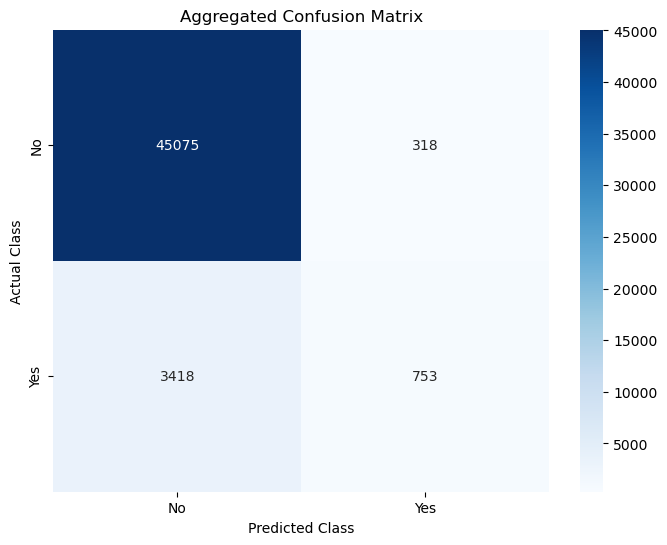

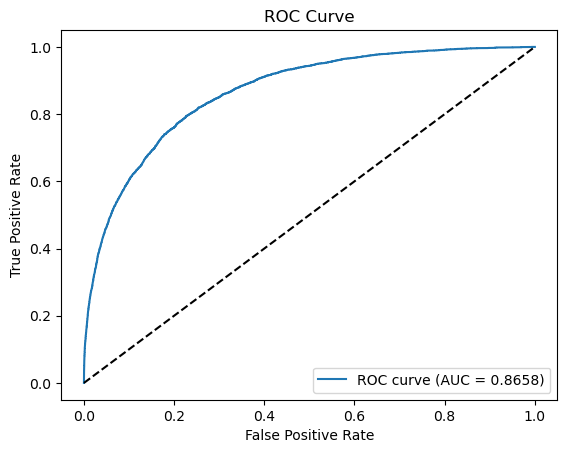

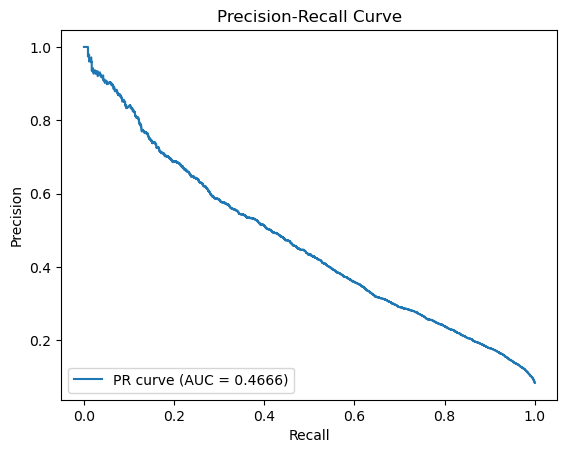


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.9433    0.9707    0.9568     45393
         1.0     0.5344    0.3654    0.4340      4171

    accuracy                         0.9198     49564
   macro avg     0.7388    0.6681    0.6954     49564
weighted avg     0.9089    0.9198    0.9128     49564



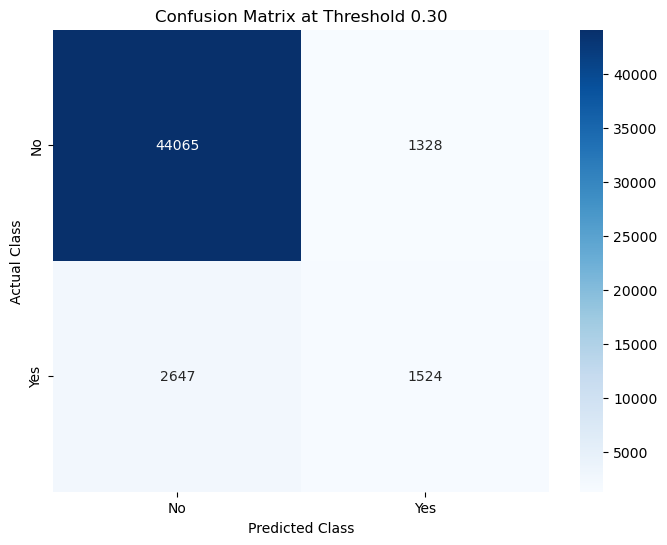

In [22]:
# Example usage
# Prepare data
X = X_train_original.values
y = y_train_original.values

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model,aggregated_cm, avg_roc_auc, avg_avg_precision, all_y_true, all_y_pred_probs = k_fold_cross_validation(
    X, y, MLP, nn.BCELoss(), torch.optim.Adam, device, k_folds=5, num_epochs=50 , patience=5, flag_patience=True
)

# Plot Aggregated Results
plot_confusion_matrix(aggregated_cm, 'Aggregated Confusion Matrix', ['No', 'Yes'])
plot_roc_curve(all_y_true, all_y_pred_probs, avg_roc_auc)
plot_pr_curve(all_y_true, all_y_pred_probs, avg_avg_precision)

# Adjust Threshold
manual_threshold_adjustment(all_y_true, all_y_pred_probs, threshold=0.3) # change threshold to 0.3



Test Data Confusion Matrix:


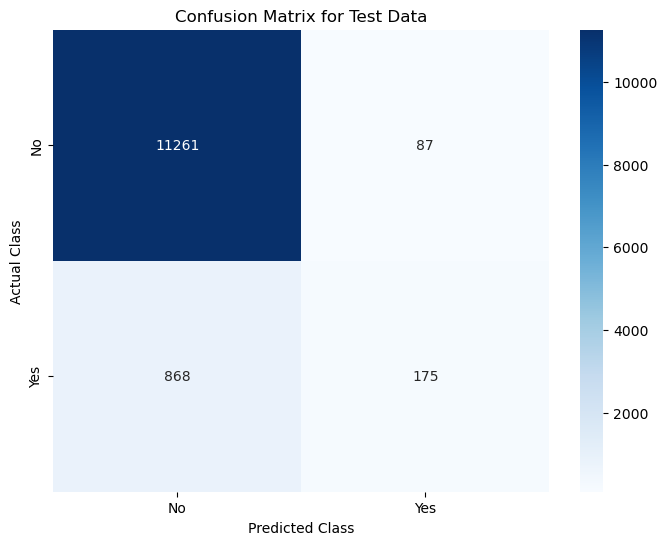

Test ROC AUC: 0.8644
Test PR AUC: 0.4390


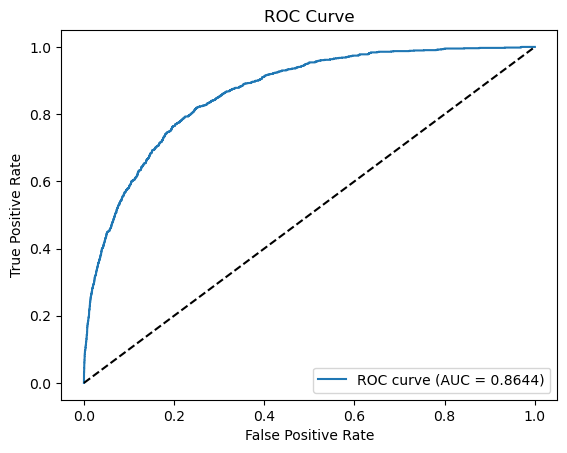

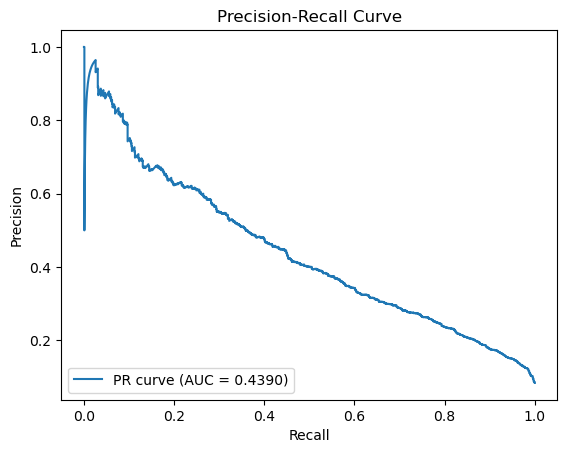


Confusion Matrix:
[[11261    87]
 [  868   175]]
Test ROC AUC: 0.8644
Test PR AUC: 0.4390


In [34]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Test the model on the original test dataset
cm, roc_auc, avg_precision = test_original_data(
    X_test=X_test_original.values,
    y_test=y_test_original.values,
    model=trained_model,  # Your trained model
    device=device
)

# Print results
print(f"\nConfusion Matrix:\n{cm}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test PR AUC: {avg_precision:.4f}")


Fold 1/5


Training Progress:   2%|▏         | 1/50 [00:00<00:33,  1.45it/s]

Epoch [1/50], Train Loss: 0.4400, Val Loss: 0.3851


Training Progress:   4%|▍         | 2/50 [00:01<00:32,  1.47it/s]

Epoch [2/50], Train Loss: 0.3930, Val Loss: 0.3629


Training Progress:   6%|▌         | 3/50 [00:02<00:31,  1.47it/s]

Epoch [3/50], Train Loss: 0.3776, Val Loss: 0.3472


Training Progress:   8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

Epoch [4/50], Train Loss: 0.3659, Val Loss: 0.3352


Training Progress:  10%|█         | 5/50 [00:03<00:30,  1.48it/s]

Epoch [5/50], Train Loss: 0.3563, Val Loss: 0.3254


Training Progress:  12%|█▏        | 6/50 [00:04<00:30,  1.44it/s]

Epoch [6/50], Train Loss: 0.3491, Val Loss: 0.3235


Training Progress:  14%|█▍        | 7/50 [00:04<00:30,  1.43it/s]

Epoch [7/50], Train Loss: 0.3426, Val Loss: 0.3137


Training Progress:  16%|█▌        | 8/50 [00:05<00:29,  1.43it/s]

Epoch [8/50], Train Loss: 0.3358, Val Loss: 0.3066


Training Progress:  18%|█▊        | 9/50 [00:06<00:28,  1.42it/s]

Epoch [9/50], Train Loss: 0.3302, Val Loss: 0.2974


Training Progress:  20%|██        | 10/50 [00:07<00:29,  1.38it/s]

Epoch [10/50], Train Loss: 0.3228, Val Loss: 0.2956


Training Progress:  22%|██▏       | 11/50 [00:07<00:28,  1.38it/s]

Epoch [11/50], Train Loss: 0.3164, Val Loss: 0.2842


Training Progress:  24%|██▍       | 12/50 [00:08<00:27,  1.39it/s]

Epoch [12/50], Train Loss: 0.3096, Val Loss: 0.2768


Training Progress:  26%|██▌       | 13/50 [00:09<00:27,  1.34it/s]

Epoch [13/50], Train Loss: 0.3037, Val Loss: 0.2729


Training Progress:  28%|██▊       | 14/50 [00:09<00:26,  1.35it/s]

Epoch [14/50], Train Loss: 0.3002, Val Loss: 0.2664


Training Progress:  30%|███       | 15/50 [00:10<00:25,  1.38it/s]

Epoch [15/50], Train Loss: 0.2955, Val Loss: 0.2639


Training Progress:  32%|███▏      | 16/50 [00:11<00:24,  1.39it/s]

Epoch [16/50], Train Loss: 0.2942, Val Loss: 0.2614


Training Progress:  34%|███▍      | 17/50 [00:12<00:23,  1.40it/s]

Epoch [17/50], Train Loss: 0.2885, Val Loss: 0.2637


Training Progress:  36%|███▌      | 18/50 [00:12<00:23,  1.37it/s]

Epoch [18/50], Train Loss: 0.2877, Val Loss: 0.2554


Training Progress:  38%|███▊      | 19/50 [00:13<00:22,  1.39it/s]

Epoch [19/50], Train Loss: 0.2845, Val Loss: 0.2551


Training Progress:  40%|████      | 20/50 [00:14<00:21,  1.42it/s]

Epoch [20/50], Train Loss: 0.2809, Val Loss: 0.2548


Training Progress:  42%|████▏     | 21/50 [00:14<00:20,  1.41it/s]

Epoch [21/50], Train Loss: 0.2814, Val Loss: 0.2518


Training Progress:  44%|████▍     | 22/50 [00:15<00:20,  1.39it/s]

Epoch [22/50], Train Loss: 0.2805, Val Loss: 0.2514


Training Progress:  46%|████▌     | 23/50 [00:16<00:19,  1.39it/s]

Epoch [23/50], Train Loss: 0.2768, Val Loss: 0.2509


Training Progress:  48%|████▊     | 24/50 [00:17<00:18,  1.38it/s]

Epoch [24/50], Train Loss: 0.2767, Val Loss: 0.2492


Training Progress:  50%|█████     | 25/50 [00:17<00:18,  1.38it/s]

Epoch [25/50], Train Loss: 0.2762, Val Loss: 0.2477


Training Progress:  52%|█████▏    | 26/50 [00:18<00:17,  1.37it/s]

Epoch [26/50], Train Loss: 0.2725, Val Loss: 0.2466


Training Progress:  54%|█████▍    | 27/50 [00:19<00:17,  1.35it/s]

Epoch [27/50], Train Loss: 0.2737, Val Loss: 0.2423


Training Progress:  56%|█████▌    | 28/50 [00:20<00:16,  1.34it/s]

Epoch [28/50], Train Loss: 0.2715, Val Loss: 0.2439


Training Progress:  58%|█████▊    | 29/50 [00:20<00:15,  1.34it/s]

Epoch [29/50], Train Loss: 0.2682, Val Loss: 0.2449


Training Progress:  60%|██████    | 30/50 [00:21<00:14,  1.36it/s]

Epoch [30/50], Train Loss: 0.2682, Val Loss: 0.2403


Training Progress:  62%|██████▏   | 31/50 [00:22<00:13,  1.38it/s]

Epoch [31/50], Train Loss: 0.2678, Val Loss: 0.2455


Training Progress:  64%|██████▍   | 32/50 [00:22<00:12,  1.40it/s]

Epoch [32/50], Train Loss: 0.2657, Val Loss: 0.2383


Training Progress:  66%|██████▌   | 33/50 [00:23<00:12,  1.41it/s]

Epoch [33/50], Train Loss: 0.2664, Val Loss: 0.2376


Training Progress:  68%|██████▊   | 34/50 [00:24<00:11,  1.41it/s]

Epoch [34/50], Train Loss: 0.2643, Val Loss: 0.2364


Training Progress:  70%|███████   | 35/50 [00:25<00:10,  1.42it/s]

Epoch [35/50], Train Loss: 0.2619, Val Loss: 0.2367


Training Progress:  72%|███████▏  | 36/50 [00:25<00:09,  1.42it/s]

Epoch [36/50], Train Loss: 0.2601, Val Loss: 0.2335


Training Progress:  74%|███████▍  | 37/50 [00:26<00:09,  1.40it/s]

Epoch [37/50], Train Loss: 0.2629, Val Loss: 0.2347


Training Progress:  76%|███████▌  | 38/50 [00:27<00:08,  1.42it/s]

Epoch [38/50], Train Loss: 0.2595, Val Loss: 0.2325


Training Progress:  78%|███████▊  | 39/50 [00:27<00:07,  1.42it/s]

Epoch [39/50], Train Loss: 0.2586, Val Loss: 0.2329


Training Progress:  80%|████████  | 40/50 [00:28<00:07,  1.42it/s]

Epoch [40/50], Train Loss: 0.2605, Val Loss: 0.2380


Training Progress:  82%|████████▏ | 41/50 [00:29<00:06,  1.43it/s]

Epoch [41/50], Train Loss: 0.2589, Val Loss: 0.2289


Training Progress:  84%|████████▍ | 42/50 [00:29<00:05,  1.43it/s]

Epoch [42/50], Train Loss: 0.2581, Val Loss: 0.2321


Training Progress:  86%|████████▌ | 43/50 [00:30<00:04,  1.41it/s]

Epoch [43/50], Train Loss: 0.2601, Val Loss: 0.2319


Training Progress:  88%|████████▊ | 44/50 [00:31<00:04,  1.39it/s]

Epoch [44/50], Train Loss: 0.2574, Val Loss: 0.2312


Training Progress:  90%|█████████ | 45/50 [00:32<00:03,  1.39it/s]

Epoch [45/50], Train Loss: 0.2564, Val Loss: 0.2322


Training Progress:  90%|█████████ | 45/50 [00:32<00:03,  1.37it/s]


Epoch [46/50], Train Loss: 0.2565, Val Loss: 0.2309
Early stopping triggered!

Fold 2/5


Training Progress:   2%|▏         | 1/50 [00:00<00:34,  1.41it/s]

Epoch [1/50], Train Loss: 0.4365, Val Loss: 0.3829


Training Progress:   4%|▍         | 2/50 [00:01<00:33,  1.43it/s]

Epoch [2/50], Train Loss: 0.3918, Val Loss: 0.3611


Training Progress:   6%|▌         | 3/50 [00:02<00:33,  1.41it/s]

Epoch [3/50], Train Loss: 0.3762, Val Loss: 0.3522


Training Progress:   8%|▊         | 4/50 [00:02<00:32,  1.43it/s]

Epoch [4/50], Train Loss: 0.3638, Val Loss: 0.3392


Training Progress:  10%|█         | 5/50 [00:03<00:32,  1.39it/s]

Epoch [5/50], Train Loss: 0.3538, Val Loss: 0.3283


Training Progress:  12%|█▏        | 6/50 [00:04<00:32,  1.34it/s]

Epoch [6/50], Train Loss: 0.3457, Val Loss: 0.3185


Training Progress:  14%|█▍        | 7/50 [00:05<00:31,  1.34it/s]

Epoch [7/50], Train Loss: 0.3412, Val Loss: 0.3136


Training Progress:  16%|█▌        | 8/50 [00:05<00:30,  1.37it/s]

Epoch [8/50], Train Loss: 0.3334, Val Loss: 0.3065


Training Progress:  18%|█▊        | 9/50 [00:06<00:29,  1.39it/s]

Epoch [9/50], Train Loss: 0.3285, Val Loss: 0.3045


Training Progress:  20%|██        | 10/50 [00:07<00:28,  1.41it/s]

Epoch [10/50], Train Loss: 0.3232, Val Loss: 0.2959


Training Progress:  22%|██▏       | 11/50 [00:07<00:27,  1.42it/s]

Epoch [11/50], Train Loss: 0.3183, Val Loss: 0.2859


Training Progress:  24%|██▍       | 12/50 [00:08<00:30,  1.26it/s]

Epoch [12/50], Train Loss: 0.3127, Val Loss: 0.2865


Training Progress:  26%|██▌       | 13/50 [00:09<00:29,  1.24it/s]

Epoch [13/50], Train Loss: 0.3075, Val Loss: 0.2781


Training Progress:  28%|██▊       | 14/50 [00:10<00:29,  1.22it/s]

Epoch [14/50], Train Loss: 0.3025, Val Loss: 0.2737


Training Progress:  30%|███       | 15/50 [00:11<00:27,  1.26it/s]

Epoch [15/50], Train Loss: 0.2987, Val Loss: 0.2699


Training Progress:  32%|███▏      | 16/50 [00:12<00:26,  1.27it/s]

Epoch [16/50], Train Loss: 0.2949, Val Loss: 0.2654


Training Progress:  34%|███▍      | 17/50 [00:12<00:25,  1.28it/s]

Epoch [17/50], Train Loss: 0.2947, Val Loss: 0.2623


Training Progress:  36%|███▌      | 18/50 [00:13<00:24,  1.33it/s]

Epoch [18/50], Train Loss: 0.2884, Val Loss: 0.2607


Training Progress:  38%|███▊      | 19/50 [00:14<00:22,  1.37it/s]

Epoch [19/50], Train Loss: 0.2863, Val Loss: 0.2605


Training Progress:  40%|████      | 20/50 [00:14<00:21,  1.40it/s]

Epoch [20/50], Train Loss: 0.2855, Val Loss: 0.2519


Training Progress:  42%|████▏     | 21/50 [00:15<00:20,  1.42it/s]

Epoch [21/50], Train Loss: 0.2833, Val Loss: 0.2536


Training Progress:  44%|████▍     | 22/50 [00:16<00:19,  1.43it/s]

Epoch [22/50], Train Loss: 0.2826, Val Loss: 0.2512


Training Progress:  46%|████▌     | 23/50 [00:16<00:18,  1.45it/s]

Epoch [23/50], Train Loss: 0.2783, Val Loss: 0.2490


Training Progress:  48%|████▊     | 24/50 [00:17<00:18,  1.43it/s]

Epoch [24/50], Train Loss: 0.2790, Val Loss: 0.2468


Training Progress:  50%|█████     | 25/50 [00:18<00:17,  1.42it/s]

Epoch [25/50], Train Loss: 0.2760, Val Loss: 0.2451


Training Progress:  52%|█████▏    | 26/50 [00:19<00:16,  1.44it/s]

Epoch [26/50], Train Loss: 0.2742, Val Loss: 0.2438


Training Progress:  54%|█████▍    | 27/50 [00:19<00:15,  1.45it/s]

Epoch [27/50], Train Loss: 0.2738, Val Loss: 0.2410


Training Progress:  56%|█████▌    | 28/50 [00:20<00:15,  1.43it/s]

Epoch [28/50], Train Loss: 0.2721, Val Loss: 0.2446


Training Progress:  58%|█████▊    | 29/50 [00:21<00:14,  1.42it/s]

Epoch [29/50], Train Loss: 0.2703, Val Loss: 0.2417


Training Progress:  60%|██████    | 30/50 [00:21<00:14,  1.41it/s]

Epoch [30/50], Train Loss: 0.2690, Val Loss: 0.2424


Training Progress:  62%|██████▏   | 31/50 [00:22<00:13,  1.40it/s]

Epoch [31/50], Train Loss: 0.2667, Val Loss: 0.2417


Training Progress:  64%|██████▍   | 32/50 [00:23<00:12,  1.39it/s]

Epoch [32/50], Train Loss: 0.2667, Val Loss: 0.2360


Training Progress:  66%|██████▌   | 33/50 [00:24<00:12,  1.38it/s]

Epoch [33/50], Train Loss: 0.2673, Val Loss: 0.2377


Training Progress:  68%|██████▊   | 34/50 [00:24<00:11,  1.41it/s]

Epoch [34/50], Train Loss: 0.2640, Val Loss: 0.2365


Training Progress:  70%|███████   | 35/50 [00:25<00:10,  1.42it/s]

Epoch [35/50], Train Loss: 0.2614, Val Loss: 0.2357


Training Progress:  72%|███████▏  | 36/50 [00:26<00:09,  1.44it/s]

Epoch [36/50], Train Loss: 0.2638, Val Loss: 0.2299


Training Progress:  74%|███████▍  | 37/50 [00:26<00:08,  1.45it/s]

Epoch [37/50], Train Loss: 0.2593, Val Loss: 0.2347


Training Progress:  76%|███████▌  | 38/50 [00:27<00:08,  1.46it/s]

Epoch [38/50], Train Loss: 0.2607, Val Loss: 0.2333


Training Progress:  78%|███████▊  | 39/50 [00:28<00:07,  1.47it/s]

Epoch [39/50], Train Loss: 0.2590, Val Loss: 0.2314


Training Progress:  80%|████████  | 40/50 [00:28<00:06,  1.47it/s]

Epoch [40/50], Train Loss: 0.2580, Val Loss: 0.2321


Training Progress:  82%|████████▏ | 41/50 [00:29<00:06,  1.46it/s]

Epoch [41/50], Train Loss: 0.2589, Val Loss: 0.2289


Training Progress:  84%|████████▍ | 42/50 [00:30<00:05,  1.46it/s]

Epoch [42/50], Train Loss: 0.2589, Val Loss: 0.2308


Training Progress:  86%|████████▌ | 43/50 [00:30<00:04,  1.46it/s]

Epoch [43/50], Train Loss: 0.2585, Val Loss: 0.2308


Training Progress:  88%|████████▊ | 44/50 [00:31<00:04,  1.42it/s]

Epoch [44/50], Train Loss: 0.2561, Val Loss: 0.2309


Training Progress:  90%|█████████ | 45/50 [00:32<00:03,  1.40it/s]

Epoch [45/50], Train Loss: 0.2541, Val Loss: 0.2258


Training Progress:  92%|█████████▏| 46/50 [00:33<00:02,  1.41it/s]

Epoch [46/50], Train Loss: 0.2564, Val Loss: 0.2258


Training Progress:  94%|█████████▍| 47/50 [00:33<00:02,  1.43it/s]

Epoch [47/50], Train Loss: 0.2550, Val Loss: 0.2249


Training Progress:  96%|█████████▌| 48/50 [00:34<00:01,  1.45it/s]

Epoch [48/50], Train Loss: 0.2519, Val Loss: 0.2273


Training Progress:  98%|█████████▊| 49/50 [00:35<00:00,  1.46it/s]

Epoch [49/50], Train Loss: 0.2520, Val Loss: 0.2228


Training Progress: 100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Epoch [50/50], Train Loss: 0.2519, Val Loss: 0.2254

Fold 3/5


Training Progress:   2%|▏         | 1/50 [00:00<00:33,  1.46it/s]

Epoch [1/50], Train Loss: 0.4399, Val Loss: 0.3805


Training Progress:   4%|▍         | 2/50 [00:01<00:32,  1.47it/s]

Epoch [2/50], Train Loss: 0.3931, Val Loss: 0.3565


Training Progress:   6%|▌         | 3/50 [00:02<00:31,  1.48it/s]

Epoch [3/50], Train Loss: 0.3756, Val Loss: 0.3413


Training Progress:   8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

Epoch [4/50], Train Loss: 0.3628, Val Loss: 0.3303


Training Progress:  10%|█         | 5/50 [00:03<00:30,  1.47it/s]

Epoch [5/50], Train Loss: 0.3553, Val Loss: 0.3239


Training Progress:  12%|█▏        | 6/50 [00:04<00:29,  1.47it/s]

Epoch [6/50], Train Loss: 0.3466, Val Loss: 0.3153


Training Progress:  14%|█▍        | 7/50 [00:04<00:29,  1.48it/s]

Epoch [7/50], Train Loss: 0.3380, Val Loss: 0.3071


Training Progress:  16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

Epoch [8/50], Train Loss: 0.3345, Val Loss: 0.2991


Training Progress:  18%|█▊        | 9/50 [00:06<00:28,  1.46it/s]

Epoch [9/50], Train Loss: 0.3281, Val Loss: 0.2931


Training Progress:  20%|██        | 10/50 [00:06<00:27,  1.47it/s]

Epoch [10/50], Train Loss: 0.3211, Val Loss: 0.2880


Training Progress:  22%|██▏       | 11/50 [00:07<00:26,  1.48it/s]

Epoch [11/50], Train Loss: 0.3162, Val Loss: 0.2829


Training Progress:  24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]

Epoch [12/50], Train Loss: 0.3094, Val Loss: 0.2786


Training Progress:  26%|██▌       | 13/50 [00:08<00:24,  1.49it/s]

Epoch [13/50], Train Loss: 0.3048, Val Loss: 0.2720


Training Progress:  28%|██▊       | 14/50 [00:09<00:24,  1.46it/s]

Epoch [14/50], Train Loss: 0.3014, Val Loss: 0.2655


Training Progress:  30%|███       | 15/50 [00:10<00:24,  1.44it/s]

Epoch [15/50], Train Loss: 0.2973, Val Loss: 0.2601


Training Progress:  32%|███▏      | 16/50 [00:10<00:23,  1.42it/s]

Epoch [16/50], Train Loss: 0.2938, Val Loss: 0.2585


Training Progress:  34%|███▍      | 17/50 [00:11<00:23,  1.40it/s]

Epoch [17/50], Train Loss: 0.2910, Val Loss: 0.2535


Training Progress:  36%|███▌      | 18/50 [00:12<00:23,  1.37it/s]

Epoch [18/50], Train Loss: 0.2890, Val Loss: 0.2559


Training Progress:  38%|███▊      | 19/50 [00:13<00:22,  1.38it/s]

Epoch [19/50], Train Loss: 0.2877, Val Loss: 0.2504


Training Progress:  40%|████      | 20/50 [00:13<00:22,  1.34it/s]

Epoch [20/50], Train Loss: 0.2849, Val Loss: 0.2497


Training Progress:  42%|████▏     | 21/50 [00:14<00:22,  1.32it/s]

Epoch [21/50], Train Loss: 0.2833, Val Loss: 0.2478


Training Progress:  44%|████▍     | 22/50 [00:15<00:21,  1.33it/s]

Epoch [22/50], Train Loss: 0.2808, Val Loss: 0.2478


Training Progress:  46%|████▌     | 23/50 [00:16<00:20,  1.34it/s]

Epoch [23/50], Train Loss: 0.2783, Val Loss: 0.2507


Training Progress:  48%|████▊     | 24/50 [00:16<00:19,  1.34it/s]

Epoch [24/50], Train Loss: 0.2782, Val Loss: 0.2422


Training Progress:  50%|█████     | 25/50 [00:17<00:18,  1.32it/s]

Epoch [25/50], Train Loss: 0.2772, Val Loss: 0.2435


Training Progress:  52%|█████▏    | 26/50 [00:18<00:17,  1.34it/s]

Epoch [26/50], Train Loss: 0.2754, Val Loss: 0.2415


Training Progress:  54%|█████▍    | 27/50 [00:19<00:17,  1.34it/s]

Epoch [27/50], Train Loss: 0.2736, Val Loss: 0.2388


Training Progress:  56%|█████▌    | 28/50 [00:20<00:16,  1.32it/s]

Epoch [28/50], Train Loss: 0.2707, Val Loss: 0.2403


Training Progress:  58%|█████▊    | 29/50 [00:20<00:15,  1.35it/s]

Epoch [29/50], Train Loss: 0.2678, Val Loss: 0.2386


Training Progress:  60%|██████    | 30/50 [00:21<00:14,  1.37it/s]

Epoch [30/50], Train Loss: 0.2694, Val Loss: 0.2349


Training Progress:  62%|██████▏   | 31/50 [00:22<00:13,  1.38it/s]

Epoch [31/50], Train Loss: 0.2673, Val Loss: 0.2356


Training Progress:  64%|██████▍   | 32/50 [00:22<00:13,  1.38it/s]

Epoch [32/50], Train Loss: 0.2663, Val Loss: 0.2332


Training Progress:  66%|██████▌   | 33/50 [00:23<00:12,  1.37it/s]

Epoch [33/50], Train Loss: 0.2674, Val Loss: 0.2341


Training Progress:  68%|██████▊   | 34/50 [00:24<00:12,  1.24it/s]

Epoch [34/50], Train Loss: 0.2642, Val Loss: 0.2340


Training Progress:  70%|███████   | 35/50 [00:25<00:11,  1.29it/s]

Epoch [35/50], Train Loss: 0.2620, Val Loss: 0.2306


Training Progress:  72%|███████▏  | 36/50 [00:26<00:11,  1.26it/s]

Epoch [36/50], Train Loss: 0.2625, Val Loss: 0.2337


Training Progress:  74%|███████▍  | 37/50 [00:26<00:09,  1.32it/s]

Epoch [37/50], Train Loss: 0.2622, Val Loss: 0.2326


Training Progress:  76%|███████▌  | 38/50 [00:27<00:09,  1.33it/s]

Epoch [38/50], Train Loss: 0.2613, Val Loss: 0.2285


Training Progress:  78%|███████▊  | 39/50 [00:28<00:08,  1.37it/s]

Epoch [39/50], Train Loss: 0.2597, Val Loss: 0.2296


Training Progress:  80%|████████  | 40/50 [00:28<00:07,  1.37it/s]

Epoch [40/50], Train Loss: 0.2586, Val Loss: 0.2301


Training Progress:  82%|████████▏ | 41/50 [00:29<00:06,  1.38it/s]

Epoch [41/50], Train Loss: 0.2584, Val Loss: 0.2300


Training Progress:  84%|████████▍ | 42/50 [00:30<00:05,  1.36it/s]

Epoch [42/50], Train Loss: 0.2579, Val Loss: 0.2252


Training Progress:  86%|████████▌ | 43/50 [00:31<00:05,  1.37it/s]

Epoch [43/50], Train Loss: 0.2576, Val Loss: 0.2296


Training Progress:  88%|████████▊ | 44/50 [00:31<00:04,  1.36it/s]

Epoch [44/50], Train Loss: 0.2585, Val Loss: 0.2274


Training Progress:  90%|█████████ | 45/50 [00:32<00:03,  1.37it/s]

Epoch [45/50], Train Loss: 0.2539, Val Loss: 0.2264


Training Progress:  92%|█████████▏| 46/50 [00:33<00:02,  1.38it/s]

Epoch [46/50], Train Loss: 0.2553, Val Loss: 0.2250


Training Progress:  94%|█████████▍| 47/50 [00:33<00:02,  1.40it/s]

Epoch [47/50], Train Loss: 0.2553, Val Loss: 0.2244


Training Progress:  96%|█████████▌| 48/50 [00:34<00:01,  1.41it/s]

Epoch [48/50], Train Loss: 0.2533, Val Loss: 0.2237


Training Progress:  98%|█████████▊| 49/50 [00:35<00:00,  1.42it/s]

Epoch [49/50], Train Loss: 0.2517, Val Loss: 0.2229


Training Progress: 100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


Epoch [50/50], Train Loss: 0.2563, Val Loss: 0.2232

Fold 4/5


Training Progress:   2%|▏         | 1/50 [00:00<00:33,  1.45it/s]

Epoch [1/50], Train Loss: 0.4396, Val Loss: 0.3794


Training Progress:   4%|▍         | 2/50 [00:01<00:32,  1.46it/s]

Epoch [2/50], Train Loss: 0.3918, Val Loss: 0.3587


Training Progress:   6%|▌         | 3/50 [00:02<00:32,  1.44it/s]

Epoch [3/50], Train Loss: 0.3738, Val Loss: 0.3444


Training Progress:   8%|▊         | 4/50 [00:02<00:31,  1.45it/s]

Epoch [4/50], Train Loss: 0.3626, Val Loss: 0.3341


Training Progress:  10%|█         | 5/50 [00:03<00:31,  1.43it/s]

Epoch [5/50], Train Loss: 0.3537, Val Loss: 0.3252


Training Progress:  12%|█▏        | 6/50 [00:04<00:30,  1.44it/s]

Epoch [6/50], Train Loss: 0.3464, Val Loss: 0.3186


Training Progress:  14%|█▍        | 7/50 [00:04<00:30,  1.42it/s]

Epoch [7/50], Train Loss: 0.3400, Val Loss: 0.3105


Training Progress:  16%|█▌        | 8/50 [00:05<00:29,  1.42it/s]

Epoch [8/50], Train Loss: 0.3351, Val Loss: 0.3069


Training Progress:  18%|█▊        | 9/50 [00:06<00:28,  1.42it/s]

Epoch [9/50], Train Loss: 0.3280, Val Loss: 0.2944


Training Progress:  20%|██        | 10/50 [00:06<00:28,  1.43it/s]

Epoch [10/50], Train Loss: 0.3207, Val Loss: 0.2861


Training Progress:  22%|██▏       | 11/50 [00:07<00:27,  1.40it/s]

Epoch [11/50], Train Loss: 0.3142, Val Loss: 0.2818


Training Progress:  24%|██▍       | 12/50 [00:08<00:26,  1.42it/s]

Epoch [12/50], Train Loss: 0.3095, Val Loss: 0.2769


Training Progress:  26%|██▌       | 13/50 [00:09<00:26,  1.41it/s]

Epoch [13/50], Train Loss: 0.3031, Val Loss: 0.2696


Training Progress:  28%|██▊       | 14/50 [00:09<00:25,  1.43it/s]

Epoch [14/50], Train Loss: 0.2984, Val Loss: 0.2696


Training Progress:  30%|███       | 15/50 [00:10<00:24,  1.42it/s]

Epoch [15/50], Train Loss: 0.2965, Val Loss: 0.2647


Training Progress:  32%|███▏      | 16/50 [00:11<00:23,  1.44it/s]

Epoch [16/50], Train Loss: 0.2926, Val Loss: 0.2597


Training Progress:  34%|███▍      | 17/50 [00:11<00:23,  1.43it/s]

Epoch [17/50], Train Loss: 0.2889, Val Loss: 0.2568


Training Progress:  36%|███▌      | 18/50 [00:12<00:22,  1.43it/s]

Epoch [18/50], Train Loss: 0.2860, Val Loss: 0.2522


Training Progress:  38%|███▊      | 19/50 [00:13<00:21,  1.42it/s]

Epoch [19/50], Train Loss: 0.2854, Val Loss: 0.2510


Training Progress:  40%|████      | 20/50 [00:14<00:20,  1.43it/s]

Epoch [20/50], Train Loss: 0.2808, Val Loss: 0.2470


Training Progress:  42%|████▏     | 21/50 [00:14<00:20,  1.43it/s]

Epoch [21/50], Train Loss: 0.2804, Val Loss: 0.2495


Training Progress:  44%|████▍     | 22/50 [00:15<00:19,  1.44it/s]

Epoch [22/50], Train Loss: 0.2807, Val Loss: 0.2479


Training Progress:  46%|████▌     | 23/50 [00:16<00:18,  1.44it/s]

Epoch [23/50], Train Loss: 0.2761, Val Loss: 0.2401


Training Progress:  48%|████▊     | 24/50 [00:16<00:17,  1.45it/s]

Epoch [24/50], Train Loss: 0.2741, Val Loss: 0.2457


Training Progress:  50%|█████     | 25/50 [00:17<00:17,  1.42it/s]

Epoch [25/50], Train Loss: 0.2740, Val Loss: 0.2465


Training Progress:  52%|█████▏    | 26/50 [00:18<00:16,  1.41it/s]

Epoch [26/50], Train Loss: 0.2734, Val Loss: 0.2382


Training Progress:  54%|█████▍    | 27/50 [00:18<00:16,  1.39it/s]

Epoch [27/50], Train Loss: 0.2698, Val Loss: 0.2359


Training Progress:  56%|█████▌    | 28/50 [00:19<00:15,  1.41it/s]

Epoch [28/50], Train Loss: 0.2691, Val Loss: 0.2358


Training Progress:  58%|█████▊    | 29/50 [00:20<00:14,  1.41it/s]

Epoch [29/50], Train Loss: 0.2703, Val Loss: 0.2371


Training Progress:  60%|██████    | 30/50 [00:21<00:14,  1.43it/s]

Epoch [30/50], Train Loss: 0.2674, Val Loss: 0.2343


Training Progress:  62%|██████▏   | 31/50 [00:21<00:13,  1.43it/s]

Epoch [31/50], Train Loss: 0.2683, Val Loss: 0.2336


Training Progress:  64%|██████▍   | 32/50 [00:22<00:12,  1.44it/s]

Epoch [32/50], Train Loss: 0.2657, Val Loss: 0.2327


Training Progress:  66%|██████▌   | 33/50 [00:23<00:12,  1.41it/s]

Epoch [33/50], Train Loss: 0.2642, Val Loss: 0.2346


Training Progress:  68%|██████▊   | 34/50 [00:23<00:11,  1.36it/s]

Epoch [34/50], Train Loss: 0.2646, Val Loss: 0.2310


Training Progress:  70%|███████   | 35/50 [00:24<00:11,  1.36it/s]

Epoch [35/50], Train Loss: 0.2618, Val Loss: 0.2337


Training Progress:  72%|███████▏  | 36/50 [00:25<00:10,  1.37it/s]

Epoch [36/50], Train Loss: 0.2626, Val Loss: 0.2351


Training Progress:  74%|███████▍  | 37/50 [00:26<00:09,  1.37it/s]

Epoch [37/50], Train Loss: 0.2596, Val Loss: 0.2337


Training Progress:  76%|███████▌  | 38/50 [00:26<00:08,  1.37it/s]

Epoch [38/50], Train Loss: 0.2594, Val Loss: 0.2311


Training Progress:  78%|███████▊  | 39/50 [00:27<00:08,  1.35it/s]

Epoch [39/50], Train Loss: 0.2575, Val Loss: 0.2275


Training Progress:  80%|████████  | 40/50 [00:28<00:07,  1.31it/s]

Epoch [40/50], Train Loss: 0.2601, Val Loss: 0.2273


Training Progress:  82%|████████▏ | 41/50 [00:29<00:06,  1.34it/s]

Epoch [41/50], Train Loss: 0.2572, Val Loss: 0.2273


Training Progress:  84%|████████▍ | 42/50 [00:29<00:05,  1.36it/s]

Epoch [42/50], Train Loss: 0.2548, Val Loss: 0.2283


Training Progress:  86%|████████▌ | 43/50 [00:30<00:05,  1.37it/s]

Epoch [43/50], Train Loss: 0.2568, Val Loss: 0.2262


Training Progress:  88%|████████▊ | 44/50 [00:31<00:04,  1.40it/s]

Epoch [44/50], Train Loss: 0.2525, Val Loss: 0.2273


Training Progress:  90%|█████████ | 45/50 [00:31<00:03,  1.41it/s]

Epoch [45/50], Train Loss: 0.2541, Val Loss: 0.2277


Training Progress:  92%|█████████▏| 46/50 [00:32<00:02,  1.42it/s]

Epoch [46/50], Train Loss: 0.2518, Val Loss: 0.2259


Training Progress:  94%|█████████▍| 47/50 [00:33<00:02,  1.44it/s]

Epoch [47/50], Train Loss: 0.2529, Val Loss: 0.2281


Training Progress:  96%|█████████▌| 48/50 [00:34<00:01,  1.45it/s]

Epoch [48/50], Train Loss: 0.2526, Val Loss: 0.2234


Training Progress:  98%|█████████▊| 49/50 [00:34<00:00,  1.46it/s]

Epoch [49/50], Train Loss: 0.2516, Val Loss: 0.2233


Training Progress: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Epoch [50/50], Train Loss: 0.2510, Val Loss: 0.2215

Fold 5/5


Training Progress:   2%|▏         | 1/50 [00:00<00:35,  1.39it/s]

Epoch [1/50], Train Loss: 0.4385, Val Loss: 0.3850


Training Progress:   4%|▍         | 2/50 [00:01<00:34,  1.41it/s]

Epoch [2/50], Train Loss: 0.3915, Val Loss: 0.3591


Training Progress:   6%|▌         | 3/50 [00:02<00:33,  1.39it/s]

Epoch [3/50], Train Loss: 0.3749, Val Loss: 0.3460


Training Progress:   8%|▊         | 4/50 [00:02<00:34,  1.34it/s]

Epoch [4/50], Train Loss: 0.3643, Val Loss: 0.3345


Training Progress:  10%|█         | 5/50 [00:03<00:32,  1.38it/s]

Epoch [5/50], Train Loss: 0.3554, Val Loss: 0.3264


Training Progress:  12%|█▏        | 6/50 [00:04<00:32,  1.36it/s]

Epoch [6/50], Train Loss: 0.3483, Val Loss: 0.3183


Training Progress:  14%|█▍        | 7/50 [00:05<00:31,  1.37it/s]

Epoch [7/50], Train Loss: 0.3387, Val Loss: 0.3112


Training Progress:  16%|█▌        | 8/50 [00:05<00:30,  1.38it/s]

Epoch [8/50], Train Loss: 0.3358, Val Loss: 0.3056


Training Progress:  18%|█▊        | 9/50 [00:06<00:29,  1.38it/s]

Epoch [9/50], Train Loss: 0.3275, Val Loss: 0.2981


Training Progress:  20%|██        | 10/50 [00:07<00:28,  1.39it/s]

Epoch [10/50], Train Loss: 0.3215, Val Loss: 0.2931


Training Progress:  22%|██▏       | 11/50 [00:07<00:28,  1.38it/s]

Epoch [11/50], Train Loss: 0.3154, Val Loss: 0.2851


Training Progress:  24%|██▍       | 12/50 [00:08<00:26,  1.41it/s]

Epoch [12/50], Train Loss: 0.3105, Val Loss: 0.2797


Training Progress:  26%|██▌       | 13/50 [00:09<00:25,  1.43it/s]

Epoch [13/50], Train Loss: 0.3077, Val Loss: 0.2778


Training Progress:  28%|██▊       | 14/50 [00:10<00:24,  1.45it/s]

Epoch [14/50], Train Loss: 0.3015, Val Loss: 0.2740


Training Progress:  30%|███       | 15/50 [00:10<00:24,  1.46it/s]

Epoch [15/50], Train Loss: 0.2976, Val Loss: 0.2641


Training Progress:  32%|███▏      | 16/50 [00:11<00:23,  1.46it/s]

Epoch [16/50], Train Loss: 0.2928, Val Loss: 0.2632


Training Progress:  34%|███▍      | 17/50 [00:12<00:22,  1.45it/s]

Epoch [17/50], Train Loss: 0.2916, Val Loss: 0.2608


Training Progress:  36%|███▌      | 18/50 [00:12<00:22,  1.44it/s]

Epoch [18/50], Train Loss: 0.2878, Val Loss: 0.2590


Training Progress:  38%|███▊      | 19/50 [00:13<00:21,  1.44it/s]

Epoch [19/50], Train Loss: 0.2884, Val Loss: 0.2591


Training Progress:  40%|████      | 20/50 [00:14<00:20,  1.44it/s]

Epoch [20/50], Train Loss: 0.2830, Val Loss: 0.2557


Training Progress:  42%|████▏     | 21/50 [00:14<00:20,  1.44it/s]

Epoch [21/50], Train Loss: 0.2823, Val Loss: 0.2519


Training Progress:  44%|████▍     | 22/50 [00:15<00:19,  1.45it/s]

Epoch [22/50], Train Loss: 0.2810, Val Loss: 0.2523


Training Progress:  46%|████▌     | 23/50 [00:16<00:18,  1.46it/s]

Epoch [23/50], Train Loss: 0.2785, Val Loss: 0.2502


Training Progress:  48%|████▊     | 24/50 [00:16<00:17,  1.46it/s]

Epoch [24/50], Train Loss: 0.2740, Val Loss: 0.2458


Training Progress:  50%|█████     | 25/50 [00:17<00:17,  1.45it/s]

Epoch [25/50], Train Loss: 0.2748, Val Loss: 0.2447


Training Progress:  52%|█████▏    | 26/50 [00:18<00:16,  1.43it/s]

Epoch [26/50], Train Loss: 0.2722, Val Loss: 0.2451


Training Progress:  54%|█████▍    | 27/50 [00:18<00:15,  1.45it/s]

Epoch [27/50], Train Loss: 0.2717, Val Loss: 0.2444


Training Progress:  56%|█████▌    | 28/50 [00:19<00:15,  1.46it/s]

Epoch [28/50], Train Loss: 0.2704, Val Loss: 0.2430


Training Progress:  58%|█████▊    | 29/50 [00:20<00:14,  1.46it/s]

Epoch [29/50], Train Loss: 0.2672, Val Loss: 0.2401


Training Progress:  60%|██████    | 30/50 [00:21<00:13,  1.47it/s]

Epoch [30/50], Train Loss: 0.2685, Val Loss: 0.2383


Training Progress:  62%|██████▏   | 31/50 [00:21<00:12,  1.47it/s]

Epoch [31/50], Train Loss: 0.2671, Val Loss: 0.2388


Training Progress:  64%|██████▍   | 32/50 [00:22<00:12,  1.48it/s]

Epoch [32/50], Train Loss: 0.2645, Val Loss: 0.2356


Training Progress:  66%|██████▌   | 33/50 [00:23<00:11,  1.48it/s]

Epoch [33/50], Train Loss: 0.2670, Val Loss: 0.2346


Training Progress:  68%|██████▊   | 34/50 [00:23<00:10,  1.48it/s]

Epoch [34/50], Train Loss: 0.2639, Val Loss: 0.2354


Training Progress:  70%|███████   | 35/50 [00:24<00:10,  1.48it/s]

Epoch [35/50], Train Loss: 0.2596, Val Loss: 0.2324


Training Progress:  72%|███████▏  | 36/50 [00:25<00:09,  1.48it/s]

Epoch [36/50], Train Loss: 0.2590, Val Loss: 0.2393


Training Progress:  74%|███████▍  | 37/50 [00:25<00:08,  1.48it/s]

Epoch [37/50], Train Loss: 0.2609, Val Loss: 0.2356


Training Progress:  76%|███████▌  | 38/50 [00:26<00:08,  1.48it/s]

Epoch [38/50], Train Loss: 0.2603, Val Loss: 0.2362


Training Progress:  78%|███████▊  | 39/50 [00:27<00:07,  1.48it/s]

Epoch [39/50], Train Loss: 0.2562, Val Loss: 0.2294


Training Progress:  80%|████████  | 40/50 [00:27<00:06,  1.46it/s]

Epoch [40/50], Train Loss: 0.2548, Val Loss: 0.2292


Training Progress:  82%|████████▏ | 41/50 [00:28<00:06,  1.42it/s]

Epoch [41/50], Train Loss: 0.2549, Val Loss: 0.2303


Training Progress:  84%|████████▍ | 42/50 [00:29<00:05,  1.44it/s]

Epoch [42/50], Train Loss: 0.2536, Val Loss: 0.2342


Training Progress:  86%|████████▌ | 43/50 [00:29<00:04,  1.45it/s]

Epoch [43/50], Train Loss: 0.2536, Val Loss: 0.2288


Training Progress:  88%|████████▊ | 44/50 [00:30<00:04,  1.45it/s]

Epoch [44/50], Train Loss: 0.2526, Val Loss: 0.2290


Training Progress:  90%|█████████ | 45/50 [00:31<00:03,  1.46it/s]

Epoch [45/50], Train Loss: 0.2535, Val Loss: 0.2268


Training Progress:  92%|█████████▏| 46/50 [00:31<00:02,  1.46it/s]

Epoch [46/50], Train Loss: 0.2531, Val Loss: 0.2260


Training Progress:  94%|█████████▍| 47/50 [00:32<00:02,  1.47it/s]

Epoch [47/50], Train Loss: 0.2530, Val Loss: 0.2277


Training Progress:  96%|█████████▌| 48/50 [00:33<00:01,  1.48it/s]

Epoch [48/50], Train Loss: 0.2524, Val Loss: 0.2270


Training Progress:  98%|█████████▊| 49/50 [00:33<00:00,  1.48it/s]

Epoch [49/50], Train Loss: 0.2496, Val Loss: 0.2262


Training Progress: 100%|██████████| 50/50 [00:34<00:00,  1.44it/s]

Epoch [50/50], Train Loss: 0.2494, Val Loss: 0.2245
Average ROC AUC across 5 folds: 0.9699
Average PR AUC across 5 folds: 0.9707


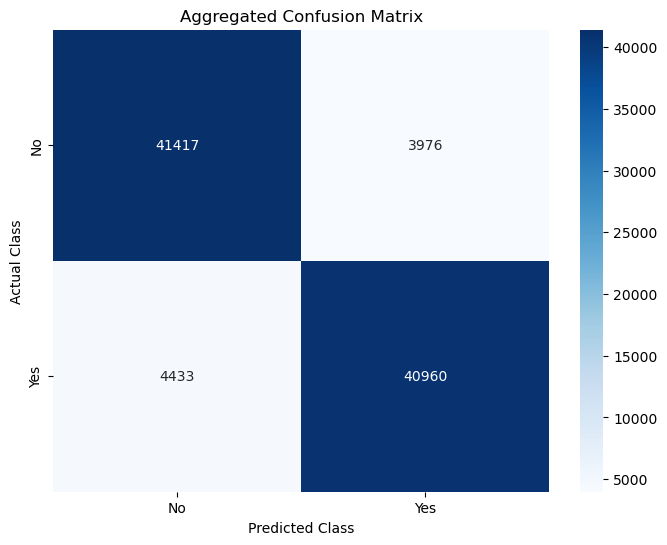

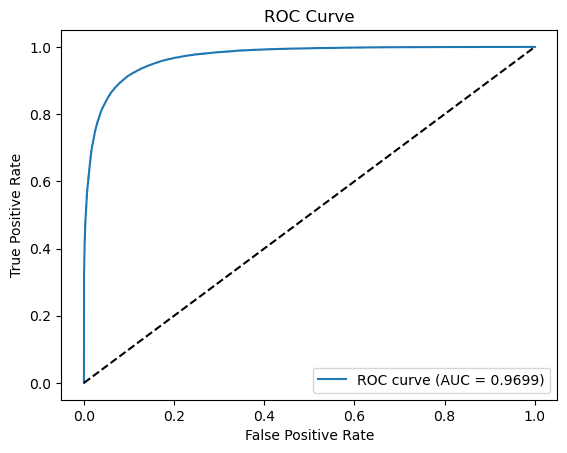

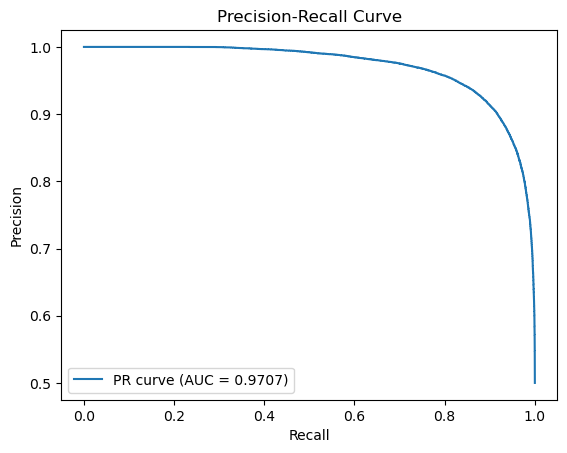


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.9529    0.8255    0.8846     45393
         1.0     0.8461    0.9592    0.8991     45393

    accuracy                         0.8923     90786
   macro avg     0.8995    0.8923    0.8918     90786
weighted avg     0.8995    0.8923    0.8918     90786



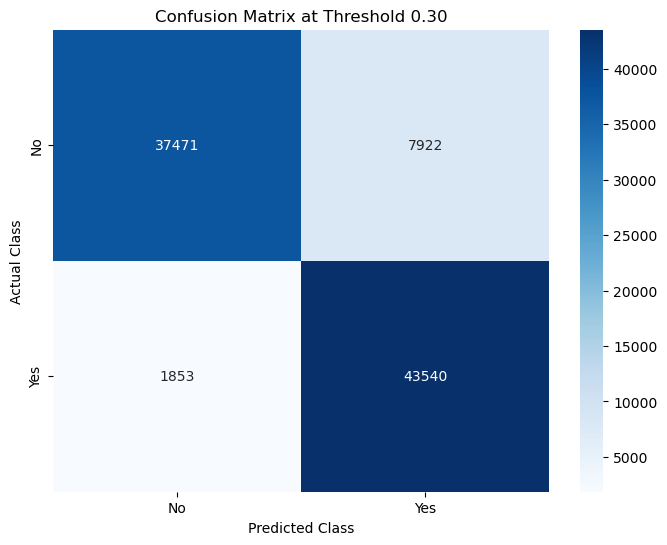

In [25]:
# Example usage
# Prepare data
X = X_train_resampled.values
y = y_train_resampled.values

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# # Prepare SMOTENC-resampled data
# categorical_features_indices = [0, 1, 2]  # Replace with actual indices
# smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train_original, y_train_original)

# X = X_train_resampled.values
# y = y_train_resampled.values

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model_smotenc, aggregated_cm, avg_roc_auc, avg_avg_precision, all_y_true, all_y_pred_probs = k_fold_cross_validation(
    X, y, MLP, nn.BCELoss(), torch.optim.Adam, device, k_folds=5, num_epochs=50 , patience=5, flag_patience=True
)

# Plot Aggregated Results
plot_confusion_matrix(aggregated_cm, 'Aggregated Confusion Matrix', ['No', 'Yes'])
plot_roc_curve(all_y_true, all_y_pred_probs, avg_roc_auc)
plot_pr_curve(all_y_true, all_y_pred_probs, avg_avg_precision)

# Adjust Threshold
manual_threshold_adjustment(all_y_true, all_y_pred_probs, threshold=0.3) # change threshold to 0.3


Test Data Confusion Matrix:


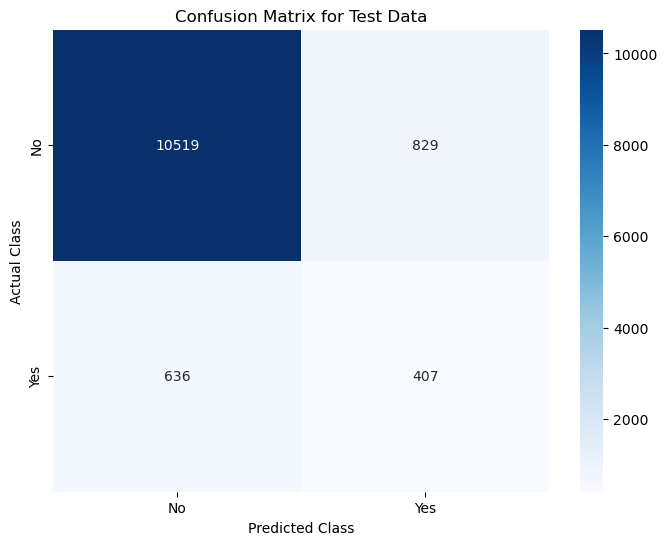

Test ROC AUC: 0.7989
Test PR AUC: 0.2972


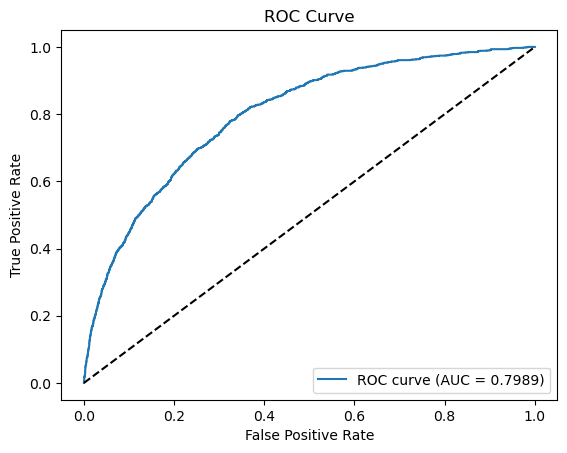

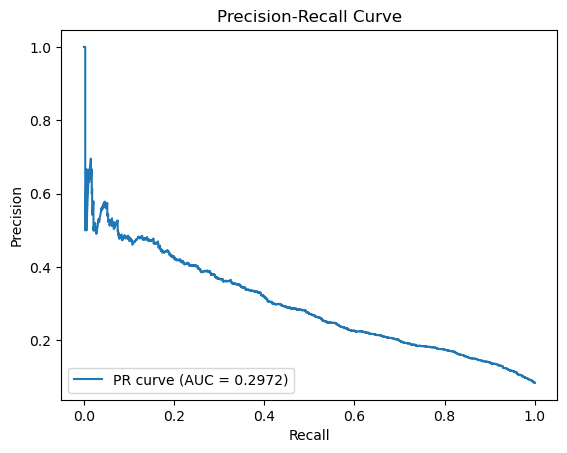

(array([[10519,   829],
        [  636,   407]]),
 0.7989264752748487,
 0.2971644261880466)

In [37]:
X = X_test_original.values
y = y_test_original.values

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Test on Original Test Data
test_original_data(
    X_test=X_test_original.values,
    y_test=y_test_original.values,
    model=trained_model_smotenc,  # Replace with the trained model
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# # Test the model on the original test dataset
# cm, roc_auc, avg_precision = test_original_data(
#     X_test=X_test_original.values,
#     y_test=y_test_original.values,
#     model=trained_model_smotenc,  # Your trained model
#     device=device
# )

# # Print results
# print(f"\nConfusion Matrix:\n{cm}")
# print(f"Test ROC AUC: {roc_auc:.4f}")
# print(f"Test PR AUC: {avg_precision:.4f}")


Fold 1/5


Training Progress:   2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch [1/50], Train Loss: 0.3956, Val Loss: 0.3647


Training Progress:   4%|▍         | 2/50 [00:01<00:39,  1.20it/s]

Epoch [2/50], Train Loss: 0.3232, Val Loss: 0.3166


Training Progress:   6%|▌         | 3/50 [00:02<00:38,  1.23it/s]

Epoch [3/50], Train Loss: 0.2865, Val Loss: 0.2816


Training Progress:   8%|▊         | 4/50 [00:03<00:37,  1.24it/s]

Epoch [4/50], Train Loss: 0.2556, Val Loss: 0.2764


Training Progress:  10%|█         | 5/50 [00:04<00:35,  1.26it/s]

Epoch [5/50], Train Loss: 0.2314, Val Loss: 0.2561


Training Progress:  12%|█▏        | 6/50 [00:04<00:35,  1.23it/s]

Epoch [6/50], Train Loss: 0.2113, Val Loss: 0.2488


Training Progress:  14%|█▍        | 7/50 [00:05<00:34,  1.23it/s]

Epoch [7/50], Train Loss: 0.1942, Val Loss: 0.2529


Training Progress:  16%|█▌        | 8/50 [00:06<00:34,  1.22it/s]

Epoch [8/50], Train Loss: 0.1804, Val Loss: 0.2542


Training Progress:  18%|█▊        | 9/50 [00:07<00:32,  1.24it/s]

Epoch [9/50], Train Loss: 0.1670, Val Loss: 0.2348


Training Progress:  20%|██        | 10/50 [00:08<00:31,  1.26it/s]

Epoch [10/50], Train Loss: 0.1562, Val Loss: 0.2210


Training Progress:  22%|██▏       | 11/50 [00:08<00:30,  1.26it/s]

Epoch [11/50], Train Loss: 0.1457, Val Loss: 0.2224


Training Progress:  24%|██▍       | 12/50 [00:09<00:29,  1.29it/s]

Epoch [12/50], Train Loss: 0.1351, Val Loss: 0.2098


Training Progress:  26%|██▌       | 13/50 [00:10<00:28,  1.30it/s]

Epoch [13/50], Train Loss: 0.1274, Val Loss: 0.2230


Training Progress:  28%|██▊       | 14/50 [00:11<00:27,  1.32it/s]

Epoch [14/50], Train Loss: 0.1181, Val Loss: 0.2213


Training Progress:  30%|███       | 15/50 [00:11<00:26,  1.33it/s]

Epoch [15/50], Train Loss: 0.1131, Val Loss: 0.2155


Training Progress:  32%|███▏      | 16/50 [00:12<00:25,  1.31it/s]

Epoch [16/50], Train Loss: 0.1060, Val Loss: 0.2120


Training Progress:  32%|███▏      | 16/50 [00:13<00:28,  1.20it/s]


Epoch [17/50], Train Loss: 0.0985, Val Loss: 0.2148
Early stopping triggered!

Fold 2/5


Training Progress:   2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

Epoch [1/50], Train Loss: 0.3917, Val Loss: 0.3467


Training Progress:   4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

Epoch [2/50], Train Loss: 0.3245, Val Loss: 0.3245


Training Progress:   6%|▌         | 3/50 [00:02<00:39,  1.19it/s]

Epoch [3/50], Train Loss: 0.2880, Val Loss: 0.2897


Training Progress:   8%|▊         | 4/50 [00:03<00:38,  1.20it/s]

Epoch [4/50], Train Loss: 0.2591, Val Loss: 0.2771


Training Progress:  10%|█         | 5/50 [00:04<00:37,  1.21it/s]

Epoch [5/50], Train Loss: 0.2337, Val Loss: 0.2536


Training Progress:  12%|█▏        | 6/50 [00:04<00:36,  1.21it/s]

Epoch [6/50], Train Loss: 0.2145, Val Loss: 0.2434


Training Progress:  14%|█▍        | 7/50 [00:05<00:35,  1.20it/s]

Epoch [7/50], Train Loss: 0.1968, Val Loss: 0.2279


Training Progress:  16%|█▌        | 8/50 [00:06<00:37,  1.11it/s]

Epoch [8/50], Train Loss: 0.1798, Val Loss: 0.2324


Training Progress:  18%|█▊        | 9/50 [00:07<00:36,  1.12it/s]

Epoch [9/50], Train Loss: 0.1676, Val Loss: 0.2143


Training Progress:  20%|██        | 10/50 [00:08<00:34,  1.15it/s]

Epoch [10/50], Train Loss: 0.1569, Val Loss: 0.2097


Training Progress:  22%|██▏       | 11/50 [00:09<00:32,  1.19it/s]

Epoch [11/50], Train Loss: 0.1456, Val Loss: 0.2195


Training Progress:  24%|██▍       | 12/50 [00:10<00:31,  1.21it/s]

Epoch [12/50], Train Loss: 0.1372, Val Loss: 0.2102


Training Progress:  26%|██▌       | 13/50 [00:10<00:30,  1.23it/s]

Epoch [13/50], Train Loss: 0.1265, Val Loss: 0.2322


Training Progress:  28%|██▊       | 14/50 [00:11<00:28,  1.25it/s]

Epoch [14/50], Train Loss: 0.1201, Val Loss: 0.2122


Training Progress:  30%|███       | 15/50 [00:12<00:27,  1.26it/s]

Epoch [15/50], Train Loss: 0.1136, Val Loss: 0.2077


Training Progress:  32%|███▏      | 16/50 [00:13<00:27,  1.25it/s]

Epoch [16/50], Train Loss: 0.1044, Val Loss: 0.2020


Training Progress:  34%|███▍      | 17/50 [00:14<00:26,  1.26it/s]

Epoch [17/50], Train Loss: 0.1015, Val Loss: 0.2111


Training Progress:  36%|███▌      | 18/50 [00:14<00:25,  1.27it/s]

Epoch [18/50], Train Loss: 0.0986, Val Loss: 0.2506


Training Progress:  38%|███▊      | 19/50 [00:15<00:24,  1.28it/s]

Epoch [19/50], Train Loss: 0.0889, Val Loss: 0.2133


Training Progress:  40%|████      | 20/50 [00:16<00:23,  1.29it/s]

Epoch [20/50], Train Loss: 0.0870, Val Loss: 0.2200


Training Progress:  40%|████      | 20/50 [00:17<00:25,  1.17it/s]


Epoch [21/50], Train Loss: 0.0815, Val Loss: 0.2293
Early stopping triggered!

Fold 3/5


Training Progress:   2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

Epoch [1/50], Train Loss: 0.3922, Val Loss: 0.3453


Training Progress:   4%|▍         | 2/50 [00:01<00:38,  1.26it/s]

Epoch [2/50], Train Loss: 0.3259, Val Loss: 0.3123


Training Progress:   6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

Epoch [3/50], Train Loss: 0.2904, Val Loss: 0.2874


Training Progress:   8%|▊         | 4/50 [00:03<00:35,  1.29it/s]

Epoch [4/50], Train Loss: 0.2600, Val Loss: 0.2765


Training Progress:  10%|█         | 5/50 [00:03<00:34,  1.29it/s]

Epoch [5/50], Train Loss: 0.2358, Val Loss: 0.2995


Training Progress:  12%|█▏        | 6/50 [00:04<00:33,  1.30it/s]

Epoch [6/50], Train Loss: 0.2140, Val Loss: 0.2474


Training Progress:  14%|█▍        | 7/50 [00:05<00:33,  1.30it/s]

Epoch [7/50], Train Loss: 0.1951, Val Loss: 0.2343


Training Progress:  16%|█▌        | 8/50 [00:06<00:32,  1.30it/s]

Epoch [8/50], Train Loss: 0.1811, Val Loss: 0.2269


Training Progress:  18%|█▊        | 9/50 [00:06<00:31,  1.30it/s]

Epoch [9/50], Train Loss: 0.1663, Val Loss: 0.2055


Training Progress:  20%|██        | 10/50 [00:07<00:30,  1.29it/s]

Epoch [10/50], Train Loss: 0.1545, Val Loss: 0.2196


Training Progress:  22%|██▏       | 11/50 [00:08<00:30,  1.27it/s]

Epoch [11/50], Train Loss: 0.1450, Val Loss: 0.2243


Training Progress:  24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

Epoch [12/50], Train Loss: 0.1346, Val Loss: 0.2162


Training Progress:  26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

Epoch [13/50], Train Loss: 0.1269, Val Loss: 0.2004


Training Progress:  28%|██▊       | 14/50 [00:10<00:28,  1.25it/s]

Epoch [14/50], Train Loss: 0.1197, Val Loss: 0.2087


Training Progress:  30%|███       | 15/50 [00:11<00:28,  1.24it/s]

Epoch [15/50], Train Loss: 0.1118, Val Loss: 0.2019


Training Progress:  32%|███▏      | 16/50 [00:12<00:27,  1.23it/s]

Epoch [16/50], Train Loss: 0.1045, Val Loss: 0.1959


Training Progress:  34%|███▍      | 17/50 [00:13<00:26,  1.23it/s]

Epoch [17/50], Train Loss: 0.0991, Val Loss: 0.2101


Training Progress:  36%|███▌      | 18/50 [00:14<00:26,  1.20it/s]

Epoch [18/50], Train Loss: 0.0968, Val Loss: 0.2071


Training Progress:  38%|███▊      | 19/50 [00:15<00:25,  1.21it/s]

Epoch [19/50], Train Loss: 0.0892, Val Loss: 0.2301


Training Progress:  40%|████      | 20/50 [00:15<00:24,  1.23it/s]

Epoch [20/50], Train Loss: 0.0841, Val Loss: 0.2005


Training Progress:  40%|████      | 20/50 [00:16<00:25,  1.20it/s]


Epoch [21/50], Train Loss: 0.0799, Val Loss: 0.2066
Early stopping triggered!

Fold 4/5


Training Progress:   2%|▏         | 1/50 [00:00<00:38,  1.29it/s]

Epoch [1/50], Train Loss: 0.3917, Val Loss: 0.3482


Training Progress:   4%|▍         | 2/50 [00:01<00:37,  1.26it/s]

Epoch [2/50], Train Loss: 0.3213, Val Loss: 0.3117


Training Progress:   6%|▌         | 3/50 [00:02<00:37,  1.26it/s]

Epoch [3/50], Train Loss: 0.2823, Val Loss: 0.2833


Training Progress:   8%|▊         | 4/50 [00:03<00:37,  1.24it/s]

Epoch [4/50], Train Loss: 0.2539, Val Loss: 0.2607


Training Progress:  10%|█         | 5/50 [00:03<00:35,  1.27it/s]

Epoch [5/50], Train Loss: 0.2277, Val Loss: 0.2461


Training Progress:  12%|█▏        | 6/50 [00:04<00:34,  1.29it/s]

Epoch [6/50], Train Loss: 0.2060, Val Loss: 0.2299


Training Progress:  14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]

Epoch [7/50], Train Loss: 0.1886, Val Loss: 0.2315


Training Progress:  16%|█▌        | 8/50 [00:06<00:31,  1.32it/s]

Epoch [8/50], Train Loss: 0.1725, Val Loss: 0.2256


Training Progress:  18%|█▊        | 9/50 [00:06<00:31,  1.30it/s]

Epoch [9/50], Train Loss: 0.1617, Val Loss: 0.2207


Training Progress:  20%|██        | 10/50 [00:07<00:32,  1.25it/s]

Epoch [10/50], Train Loss: 0.1481, Val Loss: 0.2113


Training Progress:  22%|██▏       | 11/50 [00:08<00:31,  1.22it/s]

Epoch [11/50], Train Loss: 0.1386, Val Loss: 0.2423


Training Progress:  24%|██▍       | 12/50 [00:09<00:30,  1.25it/s]

Epoch [12/50], Train Loss: 0.1304, Val Loss: 0.2151


Training Progress:  26%|██▌       | 13/50 [00:10<00:29,  1.27it/s]

Epoch [13/50], Train Loss: 0.1207, Val Loss: 0.2309


Training Progress:  28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

Epoch [14/50], Train Loss: 0.1142, Val Loss: 0.2067


Training Progress:  30%|███       | 15/50 [00:11<00:28,  1.25it/s]

Epoch [15/50], Train Loss: 0.1066, Val Loss: 0.2158


Training Progress:  32%|███▏      | 16/50 [00:12<00:26,  1.26it/s]

Epoch [16/50], Train Loss: 0.1007, Val Loss: 0.2060


Training Progress:  34%|███▍      | 17/50 [00:13<00:25,  1.28it/s]

Epoch [17/50], Train Loss: 0.0944, Val Loss: 0.2306


Training Progress:  36%|███▌      | 18/50 [00:14<00:24,  1.28it/s]

Epoch [18/50], Train Loss: 0.0900, Val Loss: 0.2122


Training Progress:  38%|███▊      | 19/50 [00:14<00:24,  1.28it/s]

Epoch [19/50], Train Loss: 0.0843, Val Loss: 0.2406


Training Progress:  40%|████      | 20/50 [00:15<00:23,  1.30it/s]

Epoch [20/50], Train Loss: 0.0790, Val Loss: 0.2118


Training Progress:  40%|████      | 20/50 [00:16<00:24,  1.21it/s]


Epoch [21/50], Train Loss: 0.0732, Val Loss: 0.2479
Early stopping triggered!

Fold 5/5


Training Progress:   2%|▏         | 1/50 [00:00<00:39,  1.26it/s]

Epoch [1/50], Train Loss: 0.3874, Val Loss: 0.3591


Training Progress:   4%|▍         | 2/50 [00:01<00:37,  1.26it/s]

Epoch [2/50], Train Loss: 0.3191, Val Loss: 0.3115


Training Progress:   6%|▌         | 3/50 [00:02<00:36,  1.29it/s]

Epoch [3/50], Train Loss: 0.2804, Val Loss: 0.2763


Training Progress:   8%|▊         | 4/50 [00:03<00:35,  1.30it/s]

Epoch [4/50], Train Loss: 0.2501, Val Loss: 0.2528


Training Progress:  10%|█         | 5/50 [00:03<00:34,  1.29it/s]

Epoch [5/50], Train Loss: 0.2236, Val Loss: 0.2429


Training Progress:  12%|█▏        | 6/50 [00:04<00:36,  1.22it/s]

Epoch [6/50], Train Loss: 0.2041, Val Loss: 0.2432


Training Progress:  14%|█▍        | 7/50 [00:05<00:37,  1.13it/s]

Epoch [7/50], Train Loss: 0.1859, Val Loss: 0.2189


Training Progress:  16%|█▌        | 8/50 [00:06<00:36,  1.14it/s]

Epoch [8/50], Train Loss: 0.1725, Val Loss: 0.2173


Training Progress:  18%|█▊        | 9/50 [00:07<00:35,  1.15it/s]

Epoch [9/50], Train Loss: 0.1614, Val Loss: 0.2224


Training Progress:  20%|██        | 10/50 [00:08<00:33,  1.19it/s]

Epoch [10/50], Train Loss: 0.1483, Val Loss: 0.2205


Training Progress:  22%|██▏       | 11/50 [00:09<00:31,  1.23it/s]

Epoch [11/50], Train Loss: 0.1381, Val Loss: 0.2223


Training Progress:  24%|██▍       | 12/50 [00:09<00:30,  1.25it/s]

Epoch [12/50], Train Loss: 0.1290, Val Loss: 0.2033


Training Progress:  26%|██▌       | 13/50 [00:10<00:28,  1.28it/s]

Epoch [13/50], Train Loss: 0.1238, Val Loss: 0.2221


Training Progress:  28%|██▊       | 14/50 [00:11<00:27,  1.29it/s]

Epoch [14/50], Train Loss: 0.1144, Val Loss: 0.2246


Training Progress:  30%|███       | 15/50 [00:12<00:26,  1.30it/s]

Epoch [15/50], Train Loss: 0.1078, Val Loss: 0.2100


Training Progress:  32%|███▏      | 16/50 [00:12<00:25,  1.32it/s]

Epoch [16/50], Train Loss: 0.1005, Val Loss: 0.2104


Training Progress:  32%|███▏      | 16/50 [00:13<00:28,  1.18it/s]

Epoch [17/50], Train Loss: 0.0962, Val Loss: 0.2301
Early stopping triggered!
Average ROC AUC across 5 folds: 0.9766
Average PR AUC across 5 folds: 0.9745


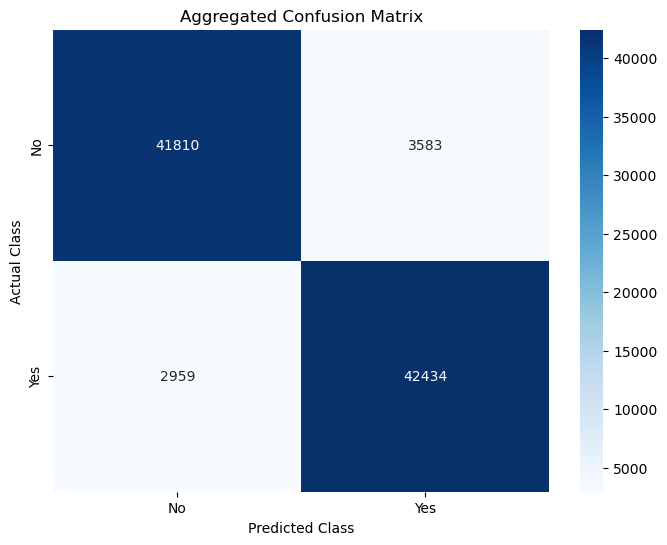

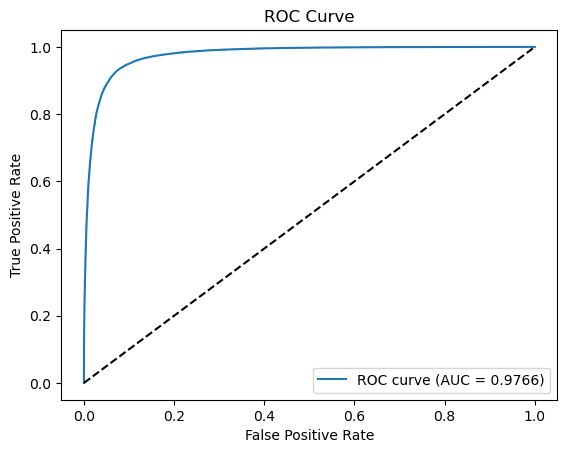

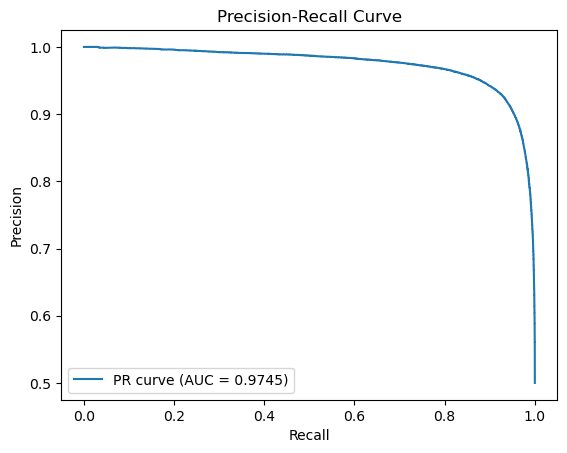


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.9531    0.8891    0.9200     45393
         1.0     0.8961    0.9563    0.9252     45393

    accuracy                         0.9227     90786
   macro avg     0.9246    0.9227    0.9226     90786
weighted avg     0.9246    0.9227    0.9226     90786



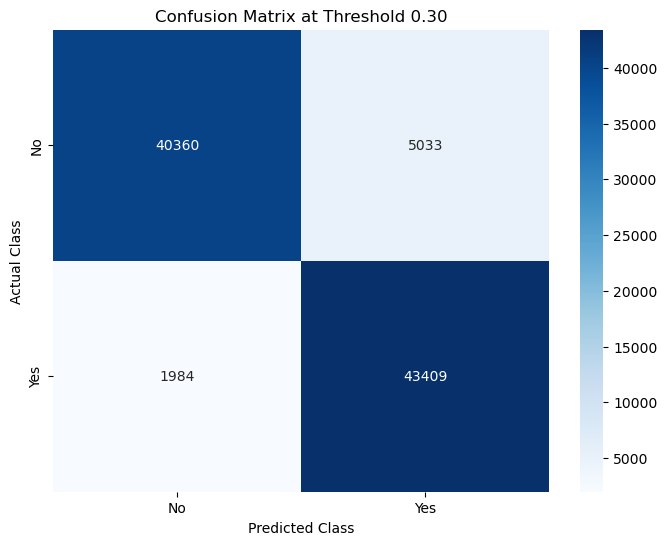

In [28]:
# Example usage
# Prepare data
X = X_train_resampled.values
y = y_train_resampled.values

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# # Prepare SMOTENC-resampled data
# categorical_features_indices = [0, 1, 2]  # Replace with actual indices
# smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train_original, y_train_original)

# X = X_train_resampled.values
# y = y_train_resampled.values

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model_big_model_smotenc, aggregated_cm, avg_roc_auc, avg_avg_precision, all_y_true, all_y_pred_probs = k_fold_cross_validation(
    X, y, BigModel, nn.BCELoss(), torch.optim.Adam, device, k_folds=5, num_epochs=50 , patience=5, flag_patience=True
)

# Plot Aggregated Results
plot_confusion_matrix(aggregated_cm, 'Aggregated Confusion Matrix', ['No', 'Yes'])
plot_roc_curve(all_y_true, all_y_pred_probs, avg_roc_auc)
plot_pr_curve(all_y_true, all_y_pred_probs, avg_avg_precision)

# Adjust Threshold
manual_threshold_adjustment(all_y_true, all_y_pred_probs, threshold=0.3) # change threshold to 0.3


Test Data Confusion Matrix:


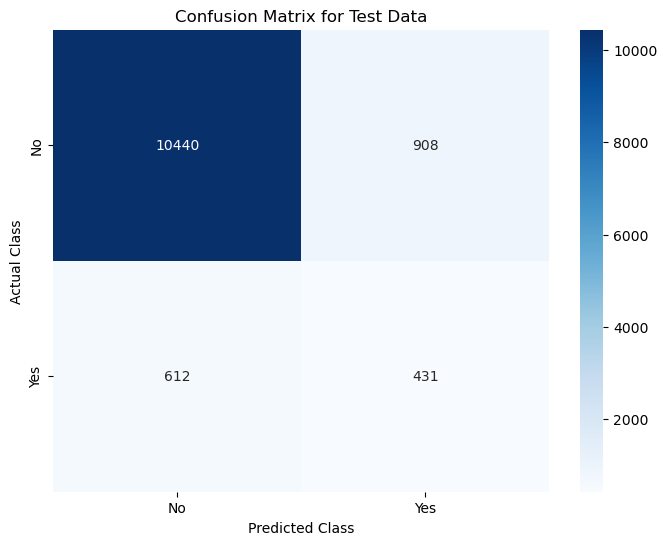

Test ROC AUC: 0.8147
Test PR AUC: 0.3226


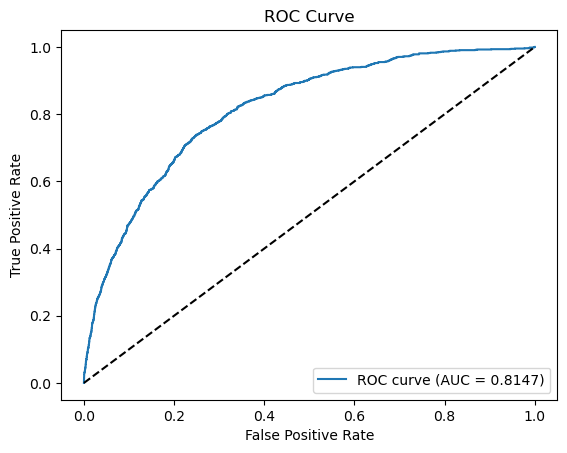

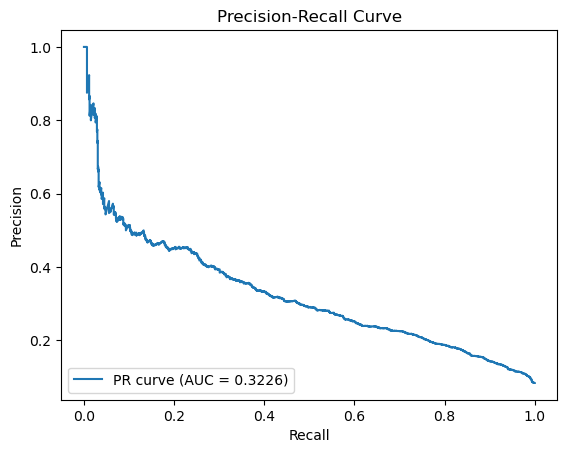


Confusion Matrix:
[[10440   908]
 [  612   431]]
Test ROC AUC: 0.8147
Test PR AUC: 0.3226


In [38]:
# trained_model_big_model_smotenc

# Test the model on the original test dataset
cm, roc_auc, avg_precision = test_original_data(
    X_test=X_test_original.values,
    y_test=y_test_original.values,
    model=trained_model_big_model_smotenc,  # Your trained model
    device=device
)

# Print results
print(f"\nConfusion Matrix:\n{cm}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test PR AUC: {avg_precision:.4f}")


Fold 1/5


Training Progress:   2%|▏         | 1/50 [00:01<01:02,  1.27s/it]

Epoch [1/50], Train Loss: 0.3956, Val Loss: 0.3644


Training Progress:   4%|▍         | 2/50 [00:02<00:58,  1.22s/it]

Epoch [2/50], Train Loss: 0.3223, Val Loss: 0.3057


Training Progress:   6%|▌         | 3/50 [00:03<00:56,  1.19s/it]

Epoch [3/50], Train Loss: 0.2827, Val Loss: 0.2763


Training Progress:   8%|▊         | 4/50 [00:04<00:54,  1.19s/it]

Epoch [4/50], Train Loss: 0.2510, Val Loss: 0.2480


Training Progress:  10%|█         | 5/50 [00:05<00:53,  1.19s/it]

Epoch [5/50], Train Loss: 0.2239, Val Loss: 0.2493


Training Progress:  12%|█▏        | 6/50 [00:07<00:51,  1.18s/it]

Epoch [6/50], Train Loss: 0.2028, Val Loss: 0.2325


Training Progress:  14%|█▍        | 7/50 [00:08<00:51,  1.21s/it]

Epoch [7/50], Train Loss: 0.1871, Val Loss: 0.2154


Training Progress:  16%|█▌        | 8/50 [00:09<00:51,  1.23s/it]

Epoch [8/50], Train Loss: 0.1726, Val Loss: 0.2027


Training Progress:  18%|█▊        | 9/50 [00:10<00:51,  1.25s/it]

Epoch [9/50], Train Loss: 0.1589, Val Loss: 0.2176


Training Progress:  20%|██        | 10/50 [00:12<00:49,  1.23s/it]

Epoch [10/50], Train Loss: 0.1493, Val Loss: 0.2021


Training Progress:  22%|██▏       | 11/50 [00:13<00:47,  1.22s/it]

Epoch [11/50], Train Loss: 0.1385, Val Loss: 0.1999


Training Progress:  24%|██▍       | 12/50 [00:14<00:45,  1.20s/it]

Epoch [12/50], Train Loss: 0.1326, Val Loss: 0.2044


Training Progress:  26%|██▌       | 13/50 [00:15<00:44,  1.19s/it]

Epoch [13/50], Train Loss: 0.1252, Val Loss: 0.1890


Training Progress:  28%|██▊       | 14/50 [00:16<00:42,  1.19s/it]

Epoch [14/50], Train Loss: 0.1194, Val Loss: 0.1850


Training Progress:  30%|███       | 15/50 [00:18<00:42,  1.20s/it]

Epoch [15/50], Train Loss: 0.1117, Val Loss: 0.1902


Training Progress:  32%|███▏      | 16/50 [00:19<00:41,  1.21s/it]

Epoch [16/50], Train Loss: 0.1067, Val Loss: 0.1813


Training Progress:  34%|███▍      | 17/50 [00:20<00:40,  1.21s/it]

Epoch [17/50], Train Loss: 0.1023, Val Loss: 0.1842


Training Progress:  36%|███▌      | 18/50 [00:21<00:38,  1.20s/it]

Epoch [18/50], Train Loss: 0.0975, Val Loss: 0.1794


Training Progress:  38%|███▊      | 19/50 [00:22<00:36,  1.19s/it]

Epoch [19/50], Train Loss: 0.0949, Val Loss: 0.1712


Training Progress:  40%|████      | 20/50 [00:24<00:35,  1.19s/it]

Epoch [20/50], Train Loss: 0.0914, Val Loss: 0.1823


Training Progress:  42%|████▏     | 21/50 [00:25<00:34,  1.19s/it]

Epoch [21/50], Train Loss: 0.0887, Val Loss: 0.1888


Training Progress:  44%|████▍     | 22/50 [00:26<00:33,  1.19s/it]

Epoch [22/50], Train Loss: 0.0856, Val Loss: 0.1902


Training Progress:  46%|████▌     | 23/50 [00:27<00:32,  1.19s/it]

Epoch [23/50], Train Loss: 0.0824, Val Loss: 0.1900


Training Progress:  46%|████▌     | 23/50 [00:28<00:33,  1.25s/it]


Epoch [24/50], Train Loss: 0.0788, Val Loss: 0.1937
Early stopping triggered!

Fold 2/5


Training Progress:   2%|▏         | 1/50 [00:01<01:08,  1.41s/it]

Epoch [1/50], Train Loss: 0.3946, Val Loss: 0.3404


Training Progress:   4%|▍         | 2/50 [00:02<01:03,  1.32s/it]

Epoch [2/50], Train Loss: 0.3202, Val Loss: 0.3042


Training Progress:   6%|▌         | 3/50 [00:03<00:59,  1.26s/it]

Epoch [3/50], Train Loss: 0.2815, Val Loss: 0.2753


Training Progress:   8%|▊         | 4/50 [00:05<00:56,  1.23s/it]

Epoch [4/50], Train Loss: 0.2506, Val Loss: 0.2525


Training Progress:  10%|█         | 5/50 [00:06<00:54,  1.22s/it]

Epoch [5/50], Train Loss: 0.2261, Val Loss: 0.2426


Training Progress:  12%|█▏        | 6/50 [00:07<00:53,  1.21s/it]

Epoch [6/50], Train Loss: 0.2052, Val Loss: 0.2451


Training Progress:  14%|█▍        | 7/50 [00:08<00:51,  1.19s/it]

Epoch [7/50], Train Loss: 0.1869, Val Loss: 0.2223


Training Progress:  16%|█▌        | 8/50 [00:09<00:50,  1.19s/it]

Epoch [8/50], Train Loss: 0.1730, Val Loss: 0.2122


Training Progress:  18%|█▊        | 9/50 [00:10<00:48,  1.18s/it]

Epoch [9/50], Train Loss: 0.1611, Val Loss: 0.2073


Training Progress:  20%|██        | 10/50 [00:12<00:47,  1.19s/it]

Epoch [10/50], Train Loss: 0.1484, Val Loss: 0.2053


Training Progress:  22%|██▏       | 11/50 [00:13<00:46,  1.19s/it]

Epoch [11/50], Train Loss: 0.1416, Val Loss: 0.2138


Training Progress:  24%|██▍       | 12/50 [00:14<00:45,  1.19s/it]

Epoch [12/50], Train Loss: 0.1345, Val Loss: 0.1965


Training Progress:  26%|██▌       | 13/50 [00:15<00:44,  1.20s/it]

Epoch [13/50], Train Loss: 0.1246, Val Loss: 0.1876


Training Progress:  28%|██▊       | 14/50 [00:16<00:43,  1.20s/it]

Epoch [14/50], Train Loss: 0.1164, Val Loss: 0.2012


Training Progress:  30%|███       | 15/50 [00:18<00:41,  1.20s/it]

Epoch [15/50], Train Loss: 0.1123, Val Loss: 0.1897


Training Progress:  32%|███▏      | 16/50 [00:19<00:41,  1.22s/it]

Epoch [16/50], Train Loss: 0.1063, Val Loss: 0.1865


Training Progress:  34%|███▍      | 17/50 [00:20<00:40,  1.23s/it]

Epoch [17/50], Train Loss: 0.1029, Val Loss: 0.1802


Training Progress:  36%|███▌      | 18/50 [00:21<00:39,  1.25s/it]

Epoch [18/50], Train Loss: 0.0976, Val Loss: 0.1716


Training Progress:  38%|███▊      | 19/50 [00:23<00:38,  1.24s/it]

Epoch [19/50], Train Loss: 0.0933, Val Loss: 0.1914


Training Progress:  40%|████      | 20/50 [00:24<00:36,  1.22s/it]

Epoch [20/50], Train Loss: 0.0889, Val Loss: 0.1742


Training Progress:  42%|████▏     | 21/50 [00:25<00:35,  1.22s/it]

Epoch [21/50], Train Loss: 0.0865, Val Loss: 0.1851


Training Progress:  44%|████▍     | 22/50 [00:26<00:34,  1.25s/it]

Epoch [22/50], Train Loss: 0.0824, Val Loss: 0.1862


Training Progress:  44%|████▍     | 22/50 [00:28<00:35,  1.28s/it]

Epoch [23/50], Train Loss: 0.0806, Val Loss: 0.1942
Early stopping triggered!

Fold 3/5



Training Progress:   2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

Epoch [1/50], Train Loss: 0.4001, Val Loss: 0.3391


Training Progress:   4%|▍         | 2/50 [00:02<01:02,  1.29s/it]

Epoch [2/50], Train Loss: 0.3246, Val Loss: 0.2993


Training Progress:   6%|▌         | 3/50 [00:03<01:01,  1.32s/it]

Epoch [3/50], Train Loss: 0.2865, Val Loss: 0.2843


Training Progress:   8%|▊         | 4/50 [00:05<01:01,  1.33s/it]

Epoch [4/50], Train Loss: 0.2547, Val Loss: 0.2568


Training Progress:  10%|█         | 5/50 [00:06<00:59,  1.32s/it]

Epoch [5/50], Train Loss: 0.2294, Val Loss: 0.2340


Training Progress:  12%|█▏        | 6/50 [00:07<00:57,  1.31s/it]

Epoch [6/50], Train Loss: 0.2074, Val Loss: 0.2240


Training Progress:  14%|█▍        | 7/50 [00:09<00:56,  1.31s/it]

Epoch [7/50], Train Loss: 0.1910, Val Loss: 0.2090


Training Progress:  16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]

Epoch [8/50], Train Loss: 0.1775, Val Loss: 0.2113


Training Progress:  18%|█▊        | 9/50 [00:11<00:53,  1.31s/it]

Epoch [9/50], Train Loss: 0.1624, Val Loss: 0.1975


Training Progress:  20%|██        | 10/50 [00:13<00:51,  1.28s/it]

Epoch [10/50], Train Loss: 0.1547, Val Loss: 0.1884


Training Progress:  22%|██▏       | 11/50 [00:14<00:49,  1.28s/it]

Epoch [11/50], Train Loss: 0.1441, Val Loss: 0.1845


Training Progress:  24%|██▍       | 12/50 [00:15<00:48,  1.26s/it]

Epoch [12/50], Train Loss: 0.1360, Val Loss: 0.1888


Training Progress:  26%|██▌       | 13/50 [00:16<00:47,  1.28s/it]

Epoch [13/50], Train Loss: 0.1284, Val Loss: 0.1868


Training Progress:  28%|██▊       | 14/50 [00:18<00:45,  1.27s/it]

Epoch [14/50], Train Loss: 0.1218, Val Loss: 0.1868


Training Progress:  30%|███       | 15/50 [00:19<00:44,  1.26s/it]

Epoch [15/50], Train Loss: 0.1153, Val Loss: 0.1967


Training Progress:  30%|███       | 15/50 [00:20<00:47,  1.37s/it]


Epoch [16/50], Train Loss: 0.1094, Val Loss: 0.2042
Early stopping triggered!

Fold 4/5


Training Progress:   2%|▏         | 1/50 [00:01<01:01,  1.26s/it]

Epoch [1/50], Train Loss: 0.3996, Val Loss: 0.3468


Training Progress:   4%|▍         | 2/50 [00:02<00:59,  1.24s/it]

Epoch [2/50], Train Loss: 0.3230, Val Loss: 0.3132


Training Progress:   6%|▌         | 3/50 [00:03<00:56,  1.21s/it]

Epoch [3/50], Train Loss: 0.2838, Val Loss: 0.2855


Training Progress:   8%|▊         | 4/50 [00:04<00:55,  1.22s/it]

Epoch [4/50], Train Loss: 0.2540, Val Loss: 0.2541


Training Progress:  10%|█         | 5/50 [00:06<00:53,  1.20s/it]

Epoch [5/50], Train Loss: 0.2280, Val Loss: 0.2358


Training Progress:  12%|█▏        | 6/50 [00:07<00:54,  1.24s/it]

Epoch [6/50], Train Loss: 0.2087, Val Loss: 0.2273


Training Progress:  14%|█▍        | 7/50 [00:08<00:53,  1.24s/it]

Epoch [7/50], Train Loss: 0.1901, Val Loss: 0.2223


Training Progress:  16%|█▌        | 8/50 [00:09<00:51,  1.23s/it]

Epoch [8/50], Train Loss: 0.1751, Val Loss: 0.2107


Training Progress:  18%|█▊        | 9/50 [00:11<00:50,  1.24s/it]

Epoch [9/50], Train Loss: 0.1644, Val Loss: 0.2145


Training Progress:  20%|██        | 10/50 [00:12<00:50,  1.25s/it]

Epoch [10/50], Train Loss: 0.1511, Val Loss: 0.1924


Training Progress:  22%|██▏       | 11/50 [00:13<00:48,  1.24s/it]

Epoch [11/50], Train Loss: 0.1424, Val Loss: 0.1977


Training Progress:  24%|██▍       | 12/50 [00:14<00:46,  1.22s/it]

Epoch [12/50], Train Loss: 0.1330, Val Loss: 0.1901


Training Progress:  26%|██▌       | 13/50 [00:15<00:44,  1.21s/it]

Epoch [13/50], Train Loss: 0.1275, Val Loss: 0.1963


Training Progress:  28%|██▊       | 14/50 [00:17<00:43,  1.21s/it]

Epoch [14/50], Train Loss: 0.1198, Val Loss: 0.1872


Training Progress:  30%|███       | 15/50 [00:18<00:42,  1.20s/it]

Epoch [15/50], Train Loss: 0.1154, Val Loss: 0.1868


Training Progress:  32%|███▏      | 16/50 [00:19<00:41,  1.22s/it]

Epoch [16/50], Train Loss: 0.1088, Val Loss: 0.1869


Training Progress:  34%|███▍      | 17/50 [00:20<00:40,  1.24s/it]

Epoch [17/50], Train Loss: 0.1033, Val Loss: 0.1910


Training Progress:  36%|███▌      | 18/50 [00:22<00:39,  1.24s/it]

Epoch [18/50], Train Loss: 0.1000, Val Loss: 0.1980


Training Progress:  38%|███▊      | 19/50 [00:23<00:38,  1.24s/it]

Epoch [19/50], Train Loss: 0.0944, Val Loss: 0.2078


Training Progress:  38%|███▊      | 19/50 [00:24<00:40,  1.30s/it]


Epoch [20/50], Train Loss: 0.0927, Val Loss: 0.1940
Early stopping triggered!

Fold 5/5


Training Progress:   2%|▏         | 1/50 [00:01<00:59,  1.20s/it]

Epoch [1/50], Train Loss: 0.3978, Val Loss: 0.3483


Training Progress:   4%|▍         | 2/50 [00:02<00:57,  1.19s/it]

Epoch [2/50], Train Loss: 0.3226, Val Loss: 0.3171


Training Progress:   6%|▌         | 3/50 [00:03<00:55,  1.19s/it]

Epoch [3/50], Train Loss: 0.2858, Val Loss: 0.2757


Training Progress:   8%|▊         | 4/50 [00:04<00:56,  1.22s/it]

Epoch [4/50], Train Loss: 0.2565, Val Loss: 0.2564


Training Progress:  10%|█         | 5/50 [00:06<00:55,  1.24s/it]

Epoch [5/50], Train Loss: 0.2309, Val Loss: 0.2388


Training Progress:  12%|█▏        | 6/50 [00:07<00:56,  1.28s/it]

Epoch [6/50], Train Loss: 0.2101, Val Loss: 0.2277


Training Progress:  14%|█▍        | 7/50 [00:08<00:55,  1.29s/it]

Epoch [7/50], Train Loss: 0.1903, Val Loss: 0.2140


Training Progress:  16%|█▌        | 8/50 [00:10<00:54,  1.30s/it]

Epoch [8/50], Train Loss: 0.1766, Val Loss: 0.2120


Training Progress:  18%|█▊        | 9/50 [00:11<00:52,  1.28s/it]

Epoch [9/50], Train Loss: 0.1639, Val Loss: 0.1999


Training Progress:  20%|██        | 10/50 [00:12<00:50,  1.27s/it]

Epoch [10/50], Train Loss: 0.1505, Val Loss: 0.1933


Training Progress:  22%|██▏       | 11/50 [00:13<00:50,  1.29s/it]

Epoch [11/50], Train Loss: 0.1415, Val Loss: 0.1926


Training Progress:  24%|██▍       | 12/50 [00:15<00:49,  1.30s/it]

Epoch [12/50], Train Loss: 0.1337, Val Loss: 0.2057


Training Progress:  26%|██▌       | 13/50 [00:16<00:47,  1.29s/it]

Epoch [13/50], Train Loss: 0.1228, Val Loss: 0.1964


Training Progress:  28%|██▊       | 14/50 [00:17<00:45,  1.26s/it]

Epoch [14/50], Train Loss: 0.1199, Val Loss: 0.1861


Training Progress:  30%|███       | 15/50 [00:18<00:43,  1.25s/it]

Epoch [15/50], Train Loss: 0.1128, Val Loss: 0.1916


Training Progress:  32%|███▏      | 16/50 [00:20<00:42,  1.26s/it]

Epoch [16/50], Train Loss: 0.1061, Val Loss: 0.1879


Training Progress:  34%|███▍      | 17/50 [00:21<00:41,  1.26s/it]

Epoch [17/50], Train Loss: 0.1022, Val Loss: 0.2037


Training Progress:  36%|███▌      | 18/50 [00:22<00:40,  1.27s/it]

Epoch [18/50], Train Loss: 0.0989, Val Loss: 0.1912


Training Progress:  36%|███▌      | 18/50 [00:23<00:42,  1.33s/it]

Epoch [19/50], Train Loss: 0.0946, Val Loss: 0.2140
Early stopping triggered!
Average ROC AUC across 5 folds: 0.9814
Average PR AUC across 5 folds: 0.9798


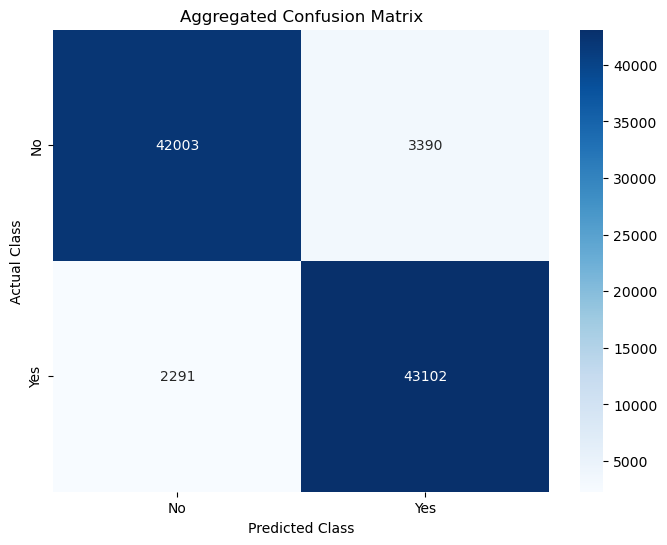

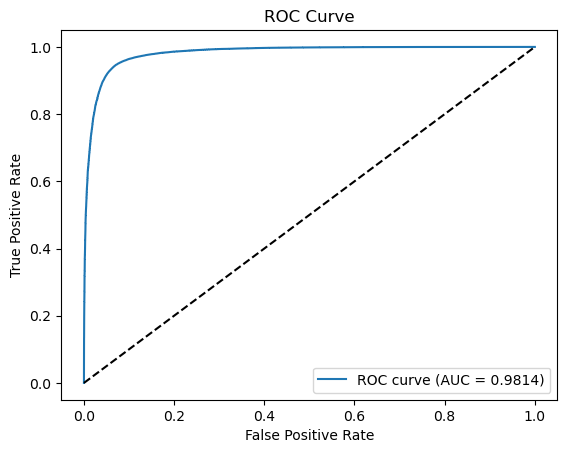

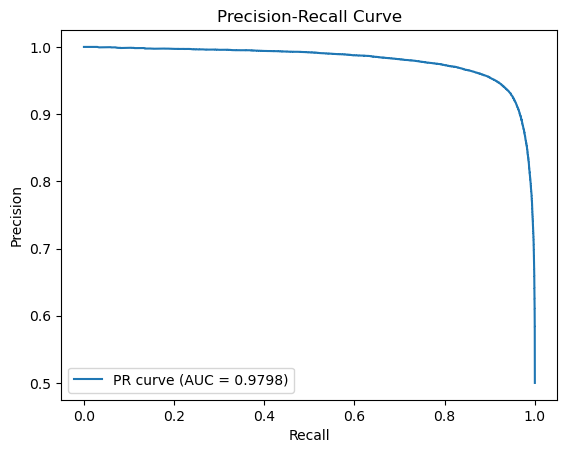


Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

         0.0     0.9625    0.8972    0.9287     45393
         1.0     0.9038    0.9651    0.9334     45393

    accuracy                         0.9311     90786
   macro avg     0.9331    0.9311    0.9311     90786
weighted avg     0.9331    0.9311    0.9311     90786



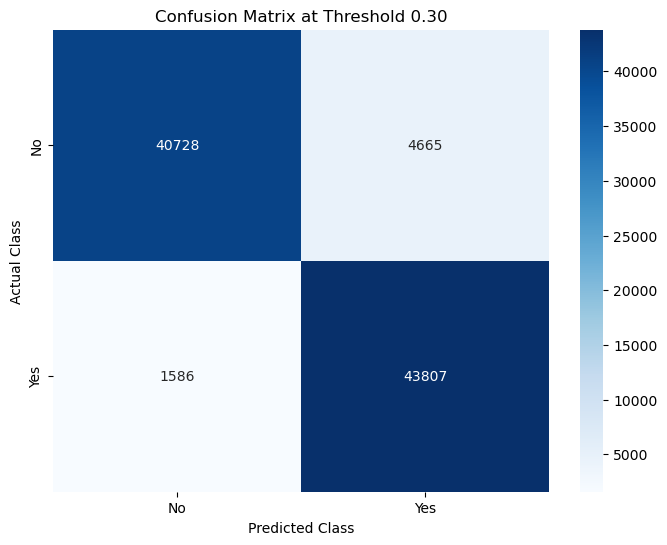

In [ ]:
# Example usage
# Prepare data
X = X_train_resampled.values
y = y_train_resampled.values

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Prepare SMOTENC-resampled data
# categorical_features_indices = [0, 1, 2]  # Replace with actual indices
# smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train_original, y_train_original)

# X = X_train_resampled.values
# y = y_train_resampled.values

# # Convert to numpy arrays
# X = np.array(X)
# y = np.array(y)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model_Hybrid_model_smotenc, aggregated_cm, avg_roc_auc, avg_avg_precision, all_y_true, all_y_pred_probs = k_fold_cross_validation(
    X, y, HybridModel, nn.BCELoss(), torch.optim.Adam, device, k_folds=5, num_epochs=50 , patience=5, flag_patience=True
)

# Plot Aggregated Results
plot_confusion_matrix(aggregated_cm, 'Aggregated Confusion Matrix', ['No', 'Yes'])
plot_roc_curve(all_y_true, all_y_pred_probs, avg_roc_auc)
plot_pr_curve(all_y_true, all_y_pred_probs, avg_avg_precision)

# Adjust Threshold
manual_threshold_adjustment(all_y_true, all_y_pred_probs, threshold=0.3) # change threshold to 0.3